### Project code I - Corruption index reconstruction

### Qian Zhang

In [157]:
# set directory

wdi_directory='../data'
corrpution_ind_directory='../data'

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the wgi

xls = pd.ExcelFile(corrpution_ind_directory+'/'+'wgidataset_filter.xlsx')

wgi_dict={'WGI.VOI.ACC':['wgi_Voice_and_Accountability',pd.DataFrame()], 
          'WGI.POLI.STAB':['wgi_Political_Stability_No_Violence',pd.DataFrame()],
          'WGI.GOV.EFF':['wgi_Government_Effectiveness',pd.DataFrame()],
          'WGI.REG.QUAL':['wgi_Regulatory_Quality',pd.DataFrame()], 
          'WGI.RULE.LAW':['wgi_Rule_of_Law',pd.DataFrame()], 
          'WGI.CON.CORR':['wgi_Control_of_Corruption',pd.DataFrame()]}

#wgi_code=['VOIACC','POLISTAB','GOVEFF','REGQUAL','RULELAW','CONCORR']

for i,key in enumerate(wgi_dict.keys()):
    wgi_dict[key][1]=xls.parse(i+1)

In [4]:
def corr_ind_process_wgi (title, abbr, df2):
    
    start_year=1996
    end_year=2018
    
    df=df2.copy()
    
    df=df.rename(columns={"Country/Territory": "Country Name", "Code": "Country Code"})
    df.insert(2, "Indicator Name", [title]*len(df), True)
    df.insert(3, "Indicator Code", [abbr]*len(df), True)
    df.insert(5, "1997", [np.NaN]*len(df), True)
    df.insert(7, "1999", [np.NaN]*len(df), True)
    df.insert(9, "2001", [np.NaN]*len(df), True)
    
    for i in range(1996,2019):
        df=df.rename(columns={i:str(i)})
    
    #print(df)

    for row in df.iterrows():
        #print(wdi_df_filter3.at[row[0],'1996'])
        data_list=[]
        t=True
        for year in range(start_year, end_year+1):
        
            if np.isnan(row[1][str(year)]):
                t=False
            data_list.append(row[1][str(year)])
        #print(t,data_list)
        if t==False:
            year_list=np.arange(start_year,end_year+1,1)
            for i,element in enumerate(data_list):
                if np.isnan(element):
                    data_list[i]=-100
                    year_list[i]=-100
                    
            if data_list.count(-100)>int(len(data_list)*2/3):
                df=df.drop(row[0])
                
            else:
                
                year_list = list(filter(lambda x: x != -100, year_list))
                data_list = list(filter(lambda x: x != -100, data_list))

                slope, intercept, r_value, p_value, std_err = linregress(year_list, data_list)
                #print(slope,intercept)
                for year in range(start_year, end_year+1):
                    if np.isnan(row[1][str(year)]):
                        df.at[row[0], str(year)]=(int(year)*slope+intercept)

    return df

In [5]:
for key, value in wgi_dict.items():
    wgi_dict[key][1]=corr_ind_process_wgi(wgi_dict[key][0],key,wgi_dict[key][1])

wgi_dict['WGI.POLI.STAB'][1].head()

Country Name Country Code                       Indicator Name  \
0        Aruba          ABW  wgi_Political_Stability_No_Violence   
1      Andorra          ADO  wgi_Political_Stability_No_Violence   
2  Afghanistan          AFG  wgi_Political_Stability_No_Violence   
3       Angola          AGO  wgi_Political_Stability_No_Violence   
4     Anguilla          AIA  wgi_Political_Stability_No_Violence   

  Indicator Code      1996      1997      1998      1999      2000      2001  \
0  WGI.POLI.STAB  1.138600  1.146033  1.153467  1.160900  1.168334  1.175767   
1  WGI.POLI.STAB  1.170157  1.240167  1.183645  1.255059  1.167002  1.269950   
2  WGI.POLI.STAB -2.414042 -2.225586 -2.422996 -2.266842 -2.440187 -2.308098   
3  WGI.POLI.STAB -2.057286 -1.814769 -2.313072 -1.633870 -2.035583 -1.452971   
4  WGI.POLI.STAB  0.806066  0.834616  0.863165  0.891715  0.920264  0.948814   

   ...      2009      2010      2011      2012      2013      2014      2015  \
0  ...  1.122499  1.100847  1.285738  1.263882  1.312226  1.164568  1.230921   
1  ...  1.296418  1.278272  1.302488  1.290351  1.283926  1.286593  1.391288   
2  ... -2.712689 -2.579152 -2.502060 -2.418561 -2.519349 -2.411068 -2.571222   
3  ... -0.347262 -0.226182 -0.369238 -0.389323 -0.391233 -0.333232 -0.500898   
4  ...  0.870086  1.373762  1.550928  1.476920  1.533980  1.164255  1.249272   

       2016      2017      2018  
0  1.284199  1.334757  1.366119  
1  1.413419  1.421572  1.425432  
2 -2.671054 -2.800609 -2.746730  
3 -0.315899 -0.331622 -0.319035  
4  1.315344  1.389161  1.297391  

[5 rows x 27 columns]

In [6]:
# transfer to 0-100 range

max_value=-1
min_value=100

for key, value in wgi_dict.items():
    for year in range(1996, 2019):
        
        if max_value<value[1][str(year)].values.max():
            max_value=value[1][str(year)].values.max()
       
        if min_value>value[1][str(year)].values.min():
            min_value=value[1][str(year)].values.min()
        
ranges=max_value-min_value

for key, value in wgi_dict.items():
    for year in range(1996, 2019):
        
        value[1][str(year)]=value[1][str(year)].apply(lambda x: (x-min_value)/ranges*100)

In [7]:
wgi_dict['WGI.POLI.STAB'][1]

Country Name Country Code                       Indicator Name  \
0               Aruba          ABW  wgi_Political_Stability_No_Violence   
1             Andorra          ADO  wgi_Political_Stability_No_Violence   
2         Afghanistan          AFG  wgi_Political_Stability_No_Violence   
3              Angola          AGO  wgi_Political_Stability_No_Violence   
4            Anguilla          AIA  wgi_Political_Stability_No_Violence   
..                ...          ...                                  ...   
209            Serbia          SRB  wgi_Political_Stability_No_Violence   
210      South Africa          ZAF  wgi_Political_Stability_No_Violence   
211  Congo, Dem. Rep.          ZAR  wgi_Political_Stability_No_Violence   
212            Zambia          ZMB  wgi_Political_Stability_No_Violence   
213          Zimbabwe          ZWE  wgi_Political_Stability_No_Violence   

    Indicator Code       1996       1997       1998       1999       2000  \
0    WGI.POLI.STAB  69.795779  69.912275  70.028771  70.145267  70.261763   
1    WGI.POLI.STAB  70.290343  71.387541  70.501715  71.620918  70.240895   
2    WGI.POLI.STAB  14.118815  17.072288  13.978483  16.425725  13.709075   
3    WGI.POLI.STAB  19.709883  23.510612  15.701208  26.345655  20.050023   
4    WGI.POLI.STAB  64.584314  65.031741  65.479169  65.926596  66.374024   
..             ...        ...        ...        ...        ...        ...   
209  WGI.POLI.STAB  35.756368  30.324439  18.426386  32.842945  26.203305   
210  WGI.POLI.STAB  46.040654  48.096124  43.435747  48.373622  48.417858   
211  WGI.POLI.STAB   9.920730  13.941914   7.370278  14.478424  13.139170   
212  WGI.POLI.STAB  49.455681  53.433320  55.392184  53.861758  52.482983   
213  WGI.POLI.STAB  44.672282  34.034021  40.360260  34.588653  31.219078   

          2001  ...       2009       2010       2011       2012       2013  \
0    70.378259  ...  69.543450  69.204119  72.101719  71.759189  72.516847   
1    71.854295  ...  72.269106  71.984718  72.364234  72.174020  72.073325   
2    15.779163  ...   9.438420  11.531211  12.739399  14.047982  12.468439   
3    29.180698  ...  46.509358  48.406924  46.164960  45.850192  45.820244   
4    66.821452  ...  65.587622  73.481228  76.257772  75.097929  75.992161   
..         ...  ...        ...        ...        ...        ...        ...   
209  35.361450  ...  44.466877  45.342120  47.518326  48.546136  50.766251   
210  48.651119  ...  50.176024  51.490471  52.328273  51.553791  51.226123   
211  15.014935  ...  20.574896  17.524333  17.269706  19.261560  17.595663   
212  54.290197  ...  60.858322  60.028232  59.940820  62.310248  58.783593   
213  35.143284  ...  33.660090  34.649557  37.136472  39.748468  41.514893   

          2014       2015       2016       2017       2018  
0    70.202745  71.242635  72.077607  72.869947  73.361448  
1    72.115127  73.755906  74.102744  74.230515  74.291005  
2    14.165413  11.655490  10.090923   8.060535   8.904934  
3    46.729242  44.101586  47.000888  46.754473  46.951739  
4    70.197841  71.530230  72.565703  73.722563  72.284351  
..         ...        ...        ...        ...        ...  
209  54.837033  55.696974  54.148137  53.312020  53.244235  
210  49.657445  48.613628  49.734002  47.601923  47.615632  
211  17.976012  18.243485  16.930687  15.103997  18.786517  
212  54.399804  54.329011  54.189737  54.242577  54.176985  
213  40.768587  42.263912  42.235991  40.845275  40.870711  

[212 rows x 27 columns]

In [8]:
# load icrg

xls2 = pd.ExcelFile(corrpution_ind_directory+'/'+'icrg20162.xls')

icrg_dict={'ICRG.GOV.STAB':['icrg_Government_Stability',pd.DataFrame()], 
          'ICRG.SOCIO.COND':['ircg_Socioeconomic_Conditions',pd.DataFrame()],
          'ICRG.INVEST.PROF':['icrg_Investment_Profile',pd.DataFrame()],
          'ICRG.INTNAL.CONFLIT':['icrg_Internal_Conflict',pd.DataFrame()], 
          'ICRG.EXTER.CONFLIT':['icrg_External_Conflict',pd.DataFrame()], 
          'ICRG.CORR':['icrg_Corruption',pd.DataFrame()],
          'ICRG.MILI.POLIT':['icrg_Military_in_Politics',pd.DataFrame()],
          'ICRG.RELIG.TENS':['icrg_Religious_Tensions',pd.DataFrame()],
          'ICRG.LAW.ORD':['icrg_Law_and_Order',pd.DataFrame()],
          'ICRG.ETHN.TENS':['icrg_Ethnic_Tensions',pd.DataFrame()],
          'ICRG.DEMO.ACC':['icrg_Democratic_Accountability',pd.DataFrame()],
          'ICRG.BUREAU.QUAL':['icrg_Bureaucracy_Quality',pd.DataFrame()]}

for i,key in enumerate(icrg_dict.keys()):
    icrg_dict[key][1]=xls2.parse(i+1)

In [9]:
def corr_ind_process_icrg (title, abbr, df2):
    
    start_year=1984
    end_year=2016
    
    df=df2.copy()
    
    df.insert(2, "Indicator Name", [title]*len(df), True)
    df.insert(3, "Indicator Code", [abbr]*len(df), True)
    
    for i in range(1984,2017):
        df=df.rename(columns={i:str(i)})
    
    
    
    #print(df)

    for row in df.iterrows():
        #print(wdi_df_filter3.at[row[0],'1996'])
        data_list=[]
        t=True
        for year in range(start_year, end_year+1):
        
            if np.isnan(row[1][str(year)]):
                t=False
            data_list.append(row[1][str(year)])
        #print(t,data_list)
        if t==False:
            year_list=np.arange(start_year,end_year+1,1)
            for i,element in enumerate(data_list):
                if np.isnan(element):
                    data_list[i]=-100
                    year_list[i]=-100
                    
            if data_list.count(-100)>int(len(data_list)*2/3):
                df=df.drop(row[0])
                
            else:
                
                year_list = list(filter(lambda x: x != -100, year_list))
                data_list = list(filter(lambda x: x != -100, data_list))

                slope, intercept, r_value, p_value, std_err = linregress(year_list, data_list)
                #print(slope,intercept)
                for year in range(start_year, end_year+1):
                    if np.isnan(row[1][str(year)]):
                        df.at[row[0], str(year)]=(int(year)*slope+intercept)

    return df

In [10]:
for key, value in icrg_dict.items():
    icrg_dict[key][1]=corr_ind_process_icrg(icrg_dict[key][0],key,icrg_dict[key][1])

In [11]:
icrg_dict['ICRG.BUREAU.QUAL'][1].head()

Country Name Country Code            Indicator Name    Indicator Code  1984  \
0      Albania          ALB  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   1.0   
1      Algeria          DZA  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   1.0   
2       Angola          AGO  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   2.0   
3    Argentina          ARG  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   2.0   
4      Armenia          ARM  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   1.0   

   1985  1986  1987      1988  1989  ...      2007  2008  2009  2010  2011  \
0   1.0   1.0   1.0  1.000000   1.0  ...  2.000000   2.0   2.0   2.0   2.0   
1   1.0   1.0   1.0  2.083333   3.0  ...  2.000000   2.0   2.0   2.0   2.0   
2   2.0   2.0   2.0  2.000000   2.0  ...  1.333333   1.5   1.5   1.5   1.5   
3   2.0   2.0   2.0  2.000000   2.0  ...  3.000000   3.0   3.0   3.0   3.0   
4   1.0   1.0   1.0  1.000000   1.0  ...  1.000000   1.0   1.0   1.0   1.0   

   2012  2013  2014  2015  2016  
0   2.0   2.0   2.0   2.0   2.0  
1   2.0   2.0   2.0   2.0   2.0  
2   1.5   1.5   1.5   1.5   1.5  
3   3.0   3.0   3.0   3.0   3.0  
4   1.0   1.0   1.0   1.0   1.0  

[5 rows x 37 columns]

In [12]:
len(set(icrg_dict['ICRG.BUREAU.QUAL'][1]['Country Code'].values)&set(wgi_dict['WGI.POLI.STAB'][1]['Country Code'].values))

140

In [13]:
ind_country_list=set(icrg_dict['ICRG.BUREAU.QUAL'][1]['Country Code'].values)&set(wgi_dict['WGI.POLI.STAB'][1]['Country Code'].values)

In [14]:
ind_country_list=list(ind_country_list)

In [15]:
ind_country_list.sort()

In [16]:
len(ind_country_list)

140

In [17]:
icrg_dict['ICRG.BUREAU.QUAL'][1]['1989'].values.min()

0.0

In [18]:
# transfer to 0-100 range

max_value1=-1
min_value1=100

max_value2=-1
min_value2=100

max_value3=-1
min_value3=100

grp1=['ICRG.GOV.STAB','ICRG.SOCIO.COND','ICRG.INVEST.PROF','ICRG.INTNAL.CONFLIT','ICRG.EXTER.CONFLIT']
grp2=['ICRG.CORR','ICRG.MILI.POLIT','ICRG.RELIG.TENS','ICRG.LAW.ORD','ICRG.ETHN.TENS',
      'ICRG.DEMO.ACC']
grp3=['ICRG.BUREAU.QUAL']

for key, value in icrg_dict.items():
    for year in range(1984, 2017):
        
        if key in grp1:
            if max_value1<value[1][str(year)].values.max():
                max_value1=value[1][str(year)].values.max()

            if min_value1>value[1][str(year)].values.min():
                min_value1=value[1][str(year)].values.min()
        
        elif key in grp2:
            if max_value2<value[1][str(year)].values.max():
                
                max_value2=value[1][str(year)].values.max()

            if min_value2>value[1][str(year)].values.min():
                min_value2=value[1][str(year)].values.min()
        
        elif key in grp3:
            #print(value[1][str(year)].values.max())
            if max_value3<value[1][str(year)].values.max():
                #print(value[1][str(year)].values.max())
                max_value3=value[1][str(year)].values.max()

            if min_value3>value[1][str(year)].values.min():
                min_value3=value[1][str(year)].values.min()
        
ranges1=max_value1-min_value1
ranges2=max_value2-min_value2
ranges3=max_value3-min_value3

for key, value in icrg_dict.items():
    for year in range(1984, 2017):
        
        if key in grp1:
            value[1][str(year)]=value[1][str(year)].apply(lambda x: (x-min_value1)/ranges1*100)
            
        elif key in grp2:
            value[1][str(year)]=value[1][str(year)].apply(lambda x: (x-min_value2)/ranges2*100)
        
        elif key in grp3:
            value[1][str(year)]=value[1][str(year)].apply(lambda x: (x-min_value3)/ranges3*100)
        

In [19]:
max_value3

4.0

In [20]:
icrg_dict['ICRG.BUREAU.QUAL'][1]['1995'].values.max()

100.0

In [21]:
icrg_dict['ICRG.BUREAU.QUAL'][1].head()

Country Name Country Code            Indicator Name    Indicator Code  \
0      Albania          ALB  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   
1      Algeria          DZA  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   
2       Angola          AGO  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   
3    Argentina          ARG  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   
4      Armenia          ARM  icrg_Bureaucracy_Quality  ICRG.BUREAU.QUAL   

        1984       1985       1986       1987       1988       1989  ...  \
0  28.202654  28.202654  28.202654  28.202654  28.202654  28.202654  ...   
1  28.202654  28.202654  28.202654  28.202654  54.129473  76.067551  ...   
2  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103  ...   
3  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103  ...   
4  28.202654  28.202654  28.202654  28.202654  28.202654  28.202654  ...   

        2007       2008       2009       2010       2011       2012  \
0  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103   
1  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103   
2  36.180137  40.168878  40.168878  40.168878  40.168878  40.168878   
3  76.067551  76.067551  76.067551  76.067551  76.067551  76.067551   
4  28.202654  28.202654  28.202654  28.202654  28.202654  28.202654   

        2013       2014       2015       2016  
0  52.135103  52.135103  52.135103  52.135103  
1  52.135103  52.135103  52.135103  52.135103  
2  40.168878  40.168878  40.168878  40.168878  
3  76.067551  76.067551  76.067551  76.067551  
4  28.202654  28.202654  28.202654  28.202654  

[5 rows x 37 columns]

In [22]:
# append the wgi df

wgi_df=pd.DataFrame()

for key, value in wgi_dict.items():
    wgi_df=wgi_df.append(value[1], ignore_index=True, sort=True)
    
dd=list(set(wgi_df['Country Code'].values))

for country in dd:
    if list(wgi_df['Country Code'].values).count(country)<6: ###
        wgi_df=wgi_df[wgi_df['Country Code']!=country]
        
icrg_df=pd.DataFrame()

for key, value in icrg_dict.items():
    icrg_df=icrg_df.append(value[1], ignore_index=True, sort=True)   
    
dd=list(set(icrg_df['Country Code'].values))

for country in dd:
    if list(icrg_df['Country Code'].values).count(country)<12:
        icrg_df=icrg_df[icrg_df['Country Code']!=country]

In [23]:
wgi_df

1996       1997       1998       1999       2000       2001  \
0     22.041031  24.856079  19.991745  26.034179  20.115307  27.212279   
1     41.791534  47.472685  45.880748  48.327660  47.482961  49.182634   
2     33.673564  34.768393  32.450330  35.133681  34.554924  35.498970   
3     54.260475  55.158695  56.056916  56.955136  57.853357  58.751577   
4     76.450366  76.718658  75.910347  76.095640  76.018427  75.472621   
...         ...        ...        ...        ...        ...        ...   
1265  34.084463  37.211416  33.132512  38.470125  33.502388  39.728834   
1266  63.438081  62.522233  62.521537  61.322381  61.751905  60.122529   
1267  26.126533  27.805215  24.949975  28.150716  27.675756  28.496217   
1268  38.777139  40.594947  39.834925  41.163960  40.733991  41.732972   
1269  47.581561  38.335265  44.425209  37.360478  36.559542  36.385691   

           2002       2003       2004       2005  ...       2013       2014  \
0     29.487092  33.496768  33.097716  34.313930  ...  32.517314  34.156969   
1     51.823921  53.053512  52.065077  52.009195  ...  52.717895  54.204668   
2     35.579747  35.077337  39.381790  40.735428  ...  37.951029  39.175876   
3     59.649798  60.548018  59.846039  62.206343  ...  67.698353  70.428444   
4     74.474308  74.241325  76.448170  75.901295  ...  73.996524  70.224232   
...         ...        ...        ...        ...  ...        ...        ...   
1265  38.367088  44.258161  44.174179  45.486606  ...  47.235438  48.394178   
1266  57.507635  57.507608  59.231440  60.854996  ...  50.853846  50.987273   
1267  31.697888  29.945037  29.160059  29.724419  ...  31.292947  31.562414   
1268  40.498957  42.597037  42.679654  42.677302  ...  47.143636  46.588026   
1269  32.699548  32.439163  31.047898  31.432910  ...  29.934153  30.147359   

           2015       2016       2017       2018  Country Code  \
0     34.437217  35.655247  36.397676  36.362414           AFG   
1     54.414484  54.615093  55.121828  55.185872           ALB   
2     38.645043  38.424074  37.770434  36.577683           DZA   
3     71.326665  72.224886  73.123106  74.021327           ASM   
4     70.671475  70.390300  70.139105  68.714234           ADO   
...         ...        ...        ...        ...           ...   
1265  47.766443  46.897768  46.072886  46.149648           SRB   
1266  52.345715  53.807081  51.609576  51.613622           ZAF   
1267  31.808998  30.993135  29.726897  28.390409           ZAR   
1268  46.603404  45.653612  43.454098  41.668687           ZMB   
1269  31.414123  32.214544  31.992062  32.587085           ZWE   

          Country Name  Indicator Code                Indicator Name  
0          Afghanistan     WGI.VOI.ACC  wgi_Voice_and_Accountability  
1              Albania     WGI.VOI.ACC  wgi_Voice_and_Accountability  
2              Algeria     WGI.VOI.ACC  wgi_Voice_and_Accountability  
3       American Samoa     WGI.VOI.ACC  wgi_Voice_and_Accountability  
4              Andorra     WGI.VOI.ACC  wgi_Voice_and_Accountability  
...                ...             ...                           ...  
1265            Serbia    WGI.CON.CORR     wgi_Control_of_Corruption  
1266      South Africa    WGI.CON.CORR     wgi_Control_of_Corruption  
1267  Congo, Dem. Rep.    WGI.CON.CORR     wgi_Control_of_Corruption  
1268            Zambia    WGI.CON.CORR     wgi_Control_of_Corruption  
1269          Zimbabwe    WGI.CON.CORR     wgi_Control_of_Corruption  

[1260 rows x 27 columns]

In [24]:
icrg_df

1984       1985       1986       1987       1988       1989  \
0     34.027608  45.579381  47.679703  47.679703  47.679703  47.679703   
1     50.305106  58.181315  60.281637  59.231476  58.706395  52.405428   
2     37.178092  46.629542  42.428897  41.378736  41.378736  41.378736   
3     33.502528  30.352044  39.803495  36.127930  30.352044  32.452366   
4     76.390520  75.393463  74.396406  73.399349  72.402292  71.405235   
...         ...        ...        ...        ...        ...        ...   
1675  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103   
1676  29.296341  28.202654  28.202654  28.202654  28.202654  28.202654   
1677  55.328368  54.254477  53.180585  52.106693  51.032801  49.958909   
1678  14.242059  28.202654  28.202654  28.202654  28.202654  28.202654   
1679  60.112585  76.067551  76.067551  76.067551  58.118215  52.135103   

           1990       1991       1992       1993  ...       2011       2012  \
0     36.127930  25.101238  29.826964  39.803495  ...  39.540954  39.540954   
1     53.980670  48.204784  31.927286  30.352044  ...  45.579381  40.591115   
2     41.378736  41.378736  29.826964  32.452366  ...  58.706395  55.030831   
3     32.452366  38.753333  44.004139  42.953978  ...  50.042566  49.780026   
4     70.408178  69.411121  68.414064  67.417007  ...  49.780026  49.517485   
...         ...        ...        ...        ...  ...        ...        ...   
1675  52.135103  52.135103  52.135103  52.135103  ...  28.202654  28.202654   
1676  28.202654  28.202654  28.202654  28.202654  ...  52.135103  52.135103   
1677  52.135103  52.135103  52.135103  52.135103  ...  28.202654  28.202654   
1678  28.202654  28.202654  28.202654  28.202654  ...  28.202654  28.202654   
1679  52.135103  52.135103  76.067551  76.067551  ...  40.168878  40.168878   

           2013       2014       2015       2016  Country Code   Country Name  \
0     48.729864  55.293372  49.780026  49.517485           ALB        Albania   
1     41.378736  47.679703  49.780026  47.154623           DZA        Algeria   
2     56.343533  48.204784  47.154623  44.791760           AGO         Angola   
3     35.602850  37.178092  48.467324  50.042566           ARG      Argentina   
4     52.667969  41.378736  35.865390  40.853656           ARM        Armenia   
...         ...        ...        ...        ...           ...            ...   
1675  28.202654  28.202654  28.202654  28.202654           VEN  Venezuela, RB   
1676  52.135103  52.135103  52.135103  52.135103           VNM        Vietnam   
1677  28.202654  28.202654  28.202654  28.202654           YEM    Yemen, Rep.   
1678  28.202654  28.202654  28.202654  28.202654           ZMB         Zambia   
1679  40.168878  40.168878  40.168878  40.168878           ZWE       Zimbabwe   

        Indicator Code             Indicator Name  
0        ICRG.GOV.STAB  icrg_Government_Stability  
1        ICRG.GOV.STAB  icrg_Government_Stability  
2        ICRG.GOV.STAB  icrg_Government_Stability  
3        ICRG.GOV.STAB  icrg_Government_Stability  
4        ICRG.GOV.STAB  icrg_Government_Stability  
...                ...                        ...  
1675  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1676  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1677  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1678  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1679  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  

[1680 rows x 37 columns]

In [25]:
wgi_df['Country Code'].value_counts()

HND    6
LVA    6
MLT    6
KWT    6
KHM    6
      ..
TJK    6
MWI    6
ARE    6
AGO    6
IRN    6
Name: Country Code, Length: 210, dtype: int64

In [26]:
icrg_df['Country Code'].value_counts()

HND    12
URY    12
MEX    12
POL    12
NAM    12
       ..
DEU    12
SGP    12
AZE    12
GNB    12
IRN    12
Name: Country Code, Length: 140, dtype: int64

In [27]:
ind_country_list=set(wgi_df['Country Code'].values)&set(icrg_df['Country Code'].values)

In [28]:
ind_country_list=list(ind_country_list)

In [29]:
len(ind_country_list)

140

In [30]:
# the intersaction of two indexes on time is 1996 to 2016

wgi_df=wgi_df.drop(['2017','2018'],axis=1)

In [31]:
wgi_df

1996       1997       1998       1999       2000       2001  \
0     22.041031  24.856079  19.991745  26.034179  20.115307  27.212279   
1     41.791534  47.472685  45.880748  48.327660  47.482961  49.182634   
2     33.673564  34.768393  32.450330  35.133681  34.554924  35.498970   
3     54.260475  55.158695  56.056916  56.955136  57.853357  58.751577   
4     76.450366  76.718658  75.910347  76.095640  76.018427  75.472621   
...         ...        ...        ...        ...        ...        ...   
1265  34.084463  37.211416  33.132512  38.470125  33.502388  39.728834   
1266  63.438081  62.522233  62.521537  61.322381  61.751905  60.122529   
1267  26.126533  27.805215  24.949975  28.150716  27.675756  28.496217   
1268  38.777139  40.594947  39.834925  41.163960  40.733991  41.732972   
1269  47.581561  38.335265  44.425209  37.360478  36.559542  36.385691   

           2002       2003       2004       2005  ...       2011       2012  \
0     29.487092  33.496768  33.097716  34.313930  ...  31.014234  32.088501   
1     51.823921  53.053512  52.065077  52.009195  ...  52.928545  52.297438   
2     35.579747  35.077337  39.381790  40.735428  ...  36.215075  37.752412   
3     59.649798  60.548018  59.846039  62.206343  ...  67.765498  68.025967   
4     74.474308  74.241325  76.448170  75.901295  ...  73.272661  74.422739   
...         ...        ...        ...        ...  ...        ...        ...   
1265  38.367088  44.258161  44.174179  45.486606  ...  47.667541  46.784545   
1266  57.507635  57.507608  59.231440  60.854996  ...  52.919114  50.140299   
1267  31.697888  29.945037  29.160059  29.724419  ...  29.579681  31.385790   
1268  40.498957  42.597037  42.679654  42.677302  ...  45.740495  47.496188   
1269  32.699548  32.439163  31.047898  31.432910  ...  29.983450  30.510125   

           2013       2014       2015       2016  Country Code  \
0     32.517314  34.156969  34.437217  35.655247           AFG   
1     52.717895  54.204668  54.414484  54.615093           ALB   
2     37.951029  39.175876  38.645043  38.424074           DZA   
3     67.698353  70.428444  71.326665  72.224886           ASM   
4     73.996524  70.224232  70.671475  70.390300           ADO   
...         ...        ...        ...        ...           ...   
1265  47.235438  48.394178  47.766443  46.897768           SRB   
1266  50.853846  50.987273  52.345715  53.807081           ZAF   
1267  31.292947  31.562414  31.808998  30.993135           ZAR   
1268  47.143636  46.588026  46.603404  45.653612           ZMB   
1269  29.934153  30.147359  31.414123  32.214544           ZWE   

          Country Name  Indicator Code                Indicator Name  
0          Afghanistan     WGI.VOI.ACC  wgi_Voice_and_Accountability  
1              Albania     WGI.VOI.ACC  wgi_Voice_and_Accountability  
2              Algeria     WGI.VOI.ACC  wgi_Voice_and_Accountability  
3       American Samoa     WGI.VOI.ACC  wgi_Voice_and_Accountability  
4              Andorra     WGI.VOI.ACC  wgi_Voice_and_Accountability  
...                ...             ...                           ...  
1265            Serbia    WGI.CON.CORR     wgi_Control_of_Corruption  
1266      South Africa    WGI.CON.CORR     wgi_Control_of_Corruption  
1267  Congo, Dem. Rep.    WGI.CON.CORR     wgi_Control_of_Corruption  
1268            Zambia    WGI.CON.CORR     wgi_Control_of_Corruption  
1269          Zimbabwe    WGI.CON.CORR     wgi_Control_of_Corruption  

[1260 rows x 25 columns]

In [32]:
icrg_df=icrg_df.drop(['1984','1985','1986','1987','1988','1989','1990','1991',
                     '1992','1993','1994','1995'], axis=1)

In [33]:
icrg_df

1996       1997       1998       1999       2000       2001  \
0     56.080992  54.505751  65.007362  62.907040  62.381959  63.169580   
1     58.181315  69.733087  69.733087  66.582604  65.532443  55.030831   
2     52.930509  59.756557  68.157846  70.258168  72.883571  71.308329   
3     51.880348  51.355267  62.381959  66.582604  68.682926  55.293372   
4     64.425836  63.428779  62.431722  68.157846  58.706395  50.830187   
...         ...        ...        ...        ...        ...        ...   
1675  52.135103  42.163249  28.202654  28.202654  28.202654  28.202654   
1676  52.135103  52.135103  52.135103  52.135103  52.135103  52.135103   
1677  52.135103  42.163249  28.202654  28.202654  28.202654  28.202654   
1678  28.202654  28.202654  28.202654  28.202654  28.202654  28.202654   
1679  76.067551  66.095698  52.135103  52.135103  52.135103  52.135103   

           2002       2003       2004       2005  ...       2011       2012  \
0     60.281637  61.331798  50.042566  50.305106  ...  39.540954  39.540954   
1     57.656234  54.505751  58.706395  65.269903  ...  45.579381  40.591115   
2     64.219741  65.007362  66.582604  66.582604  ...  58.706395  55.030831   
3     37.178092  46.629542  57.918774  57.393694  ...  50.042566  49.780026   
4     47.679703  55.818452  57.918774  53.193049  ...  49.780026  49.517485   
...         ...        ...        ...        ...  ...        ...        ...   
1675  28.202654  28.202654  28.202654  28.202654  ...  28.202654  28.202654   
1676  52.135103  52.135103  52.135103  52.135103  ...  52.135103  52.135103   
1677  28.202654  28.202654  28.202654  28.202654  ...  28.202654  28.202654   
1678  28.202654  28.202654  28.202654  28.202654  ...  28.202654  28.202654   
1679  52.135103  52.135103  52.135103  41.166064  ...  40.168878  40.168878   

           2013       2014       2015       2016  Country Code   Country Name  \
0     48.729864  55.293372  49.780026  49.517485           ALB        Albania   
1     41.378736  47.679703  49.780026  47.154623           DZA        Algeria   
2     56.343533  48.204784  47.154623  44.791760           AGO         Angola   
3     35.602850  37.178092  48.467324  50.042566           ARG      Argentina   
4     52.667969  41.378736  35.865390  40.853656           ARM        Armenia   
...         ...        ...        ...        ...           ...            ...   
1675  28.202654  28.202654  28.202654  28.202654           VEN  Venezuela, RB   
1676  52.135103  52.135103  52.135103  52.135103           VNM        Vietnam   
1677  28.202654  28.202654  28.202654  28.202654           YEM    Yemen, Rep.   
1678  28.202654  28.202654  28.202654  28.202654           ZMB         Zambia   
1679  40.168878  40.168878  40.168878  40.168878           ZWE       Zimbabwe   

        Indicator Code             Indicator Name  
0        ICRG.GOV.STAB  icrg_Government_Stability  
1        ICRG.GOV.STAB  icrg_Government_Stability  
2        ICRG.GOV.STAB  icrg_Government_Stability  
3        ICRG.GOV.STAB  icrg_Government_Stability  
4        ICRG.GOV.STAB  icrg_Government_Stability  
...                ...                        ...  
1675  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1676  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1677  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1678  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  
1679  ICRG.BUREAU.QUAL   icrg_Bureaucracy_Quality  

[1680 rows x 25 columns]

In [34]:
ind_df=pd.DataFrame()

for country in ind_country_list:
    
    temp=wgi_df[wgi_df['Country Code']==country]
    temp2=icrg_df[icrg_df['Country Code']==country]
    
    ind_df=ind_df.append(temp, ignore_index=True, sort=True) 
    ind_df=ind_df.append(temp2, ignore_index=True, sort=True)

In [35]:
ind_df=ind_df.sort_values('Country Code')

In [36]:
ind_df=ind_df.reset_index()

In [37]:
ind_df=ind_df.drop('index',axis=1)

In [38]:
ind_df=ind_df.sort_values(['Country Code','Indicator Code'])

In [39]:
ind_df

1996       1997       1998       1999       2000       2001  \
3     76.067551  42.163249  26.208283  28.202654  28.202654  28.202654   
0     41.045025  32.460897  28.168833  28.168833  28.168833  28.168833   
2     41.045025  41.045025  41.045025  41.045025  41.045025  41.045025   
14    41.045025  41.045025  41.045025  41.045025  41.045025  41.045025   
6     66.582604  65.007362  57.131154  43.479059  47.679703  50.830187   
...         ...        ...        ...        ...        ...        ...   
2513  46.955882  40.340366  46.712311  39.241702  39.423896  38.143038   
2514  44.672282  34.034021  40.360260  34.588653  31.219078  35.143284   
2510  39.949941  28.136637  40.943275  27.403764  29.750622  26.670890   
2512  39.190914  30.307584  41.661989  29.907850  30.942075  29.508116   
2515  42.367443  33.144845  39.573723  32.803356  34.941463  32.461866   

           2002       2003       2004       2005  ...       2011       2012  \
3     28.202654  28.202654  28.202654  28.202654  ...  40.168878  40.168878   
0     28.168833  28.168833  28.168833  28.168833  ...  28.168833  23.876769   
2     41.045025  41.045025  28.168833  28.168833  ...  34.606929  34.606929   
14    41.045025  41.045025  41.045025  41.045025  ...  41.045025  41.045025   
6     62.644500  67.895305  70.520708  72.883571  ...  72.883571  72.883571   
...         ...        ...        ...        ...  ...        ...        ...   
2513  37.719294  36.175180  36.265351  31.081071  ...  30.456004  31.009820   
2514  28.099222  34.895156  33.027724  32.002556  ...  37.136472  39.748468   
2510  21.655398  20.991526  19.607073  16.905245  ...  21.627920  22.354657   
2512  26.988368  25.295976  23.716033  23.455308  ...  24.060676  26.406572   
2515  30.585076  29.522027  27.604006  25.701987  ...  29.011581  28.882982   

           2013       2014       2015       2016  Country Code  Country Name  \
3     40.168878  40.168878  40.168878  40.168878           AGO        Angola   
0     21.730737  21.194229  15.292641  15.292641           AGO        Angola   
2     34.606929  34.606929  34.606929  34.606929           AGO        Angola   
14    41.045025  41.045025  41.045025  41.045025           AGO        Angola   
6     72.883571  71.308329  69.733087  69.733087           AGO        Angola   
...         ...        ...        ...        ...           ...           ...   
2513  31.930533  32.979176  33.805537  33.797995           ZWE      Zimbabwe   
2514  41.514893  40.768587  42.263912  42.235991           ZWE      Zimbabwe   
2510  23.056957  22.125883  26.037169  24.994103           ZWE      Zimbabwe   
2512  27.202989  29.521053  31.303303  30.508764           ZWE      Zimbabwe   
2515  30.226830  32.252531  33.679621  33.443241           ZWE      Zimbabwe   

          Indicator Code                       Indicator Name  
3       ICRG.BUREAU.QUAL             icrg_Bureaucracy_Quality  
0              ICRG.CORR                      icrg_Corruption  
2          ICRG.DEMO.ACC       icrg_Democratic_Accountability  
14        ICRG.ETHN.TENS                 icrg_Ethnic_Tensions  
6     ICRG.EXTER.CONFLIT               icrg_External_Conflict  
...                  ...                                  ...  
2513         WGI.GOV.EFF         wgi_Government_Effectiveness  
2514       WGI.POLI.STAB  wgi_Political_Stability_No_Violence  
2510        WGI.REG.QUAL               wgi_Regulatory_Quality  
2512        WGI.RULE.LAW                      wgi_Rule_of_Law  
2515         WGI.VOI.ACC         wgi_Voice_and_Accountability  

[2520 rows x 25 columns]

In [40]:
dd=list(ind_df)

In [41]:
dd=dd[-4:]+dd[:-4]

In [42]:
dd=[dd[1]]+[dd[0]]+[dd[3]]+[dd[2]]+dd[4:]

In [43]:
dd

['Country Name',
 'Country Code',
 'Indicator Name',
 'Indicator Code',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [44]:
ind_df=ind_df[dd]

In [45]:
ind_df

Country Name Country Code                       Indicator Name  \
3          Angola          AGO             icrg_Bureaucracy_Quality   
0          Angola          AGO                      icrg_Corruption   
2          Angola          AGO       icrg_Democratic_Accountability   
14         Angola          AGO                 icrg_Ethnic_Tensions   
6          Angola          AGO               icrg_External_Conflict   
...           ...          ...                                  ...   
2513     Zimbabwe          ZWE         wgi_Government_Effectiveness   
2514     Zimbabwe          ZWE  wgi_Political_Stability_No_Violence   
2510     Zimbabwe          ZWE               wgi_Regulatory_Quality   
2512     Zimbabwe          ZWE                      wgi_Rule_of_Law   
2515     Zimbabwe          ZWE         wgi_Voice_and_Accountability   

          Indicator Code       1996       1997       1998       1999  \
3       ICRG.BUREAU.QUAL  76.067551  42.163249  26.208283  28.202654   
0              ICRG.CORR  41.045025  32.460897  28.168833  28.168833   
2          ICRG.DEMO.ACC  41.045025  41.045025  41.045025  41.045025   
14        ICRG.ETHN.TENS  41.045025  41.045025  41.045025  41.045025   
6     ICRG.EXTER.CONFLIT  66.582604  65.007362  57.131154  43.479059   
...                  ...        ...        ...        ...        ...   
2513         WGI.GOV.EFF  46.955882  40.340366  46.712311  39.241702   
2514       WGI.POLI.STAB  44.672282  34.034021  40.360260  34.588653   
2510        WGI.REG.QUAL  39.949941  28.136637  40.943275  27.403764   
2512        WGI.RULE.LAW  39.190914  30.307584  41.661989  29.907850   
2515         WGI.VOI.ACC  42.367443  33.144845  39.573723  32.803356   

           2000       2001  ...       2007       2008       2009       2010  \
3     28.202654  28.202654  ...  36.180137  40.168878  40.168878  40.168878   
0     28.168833  28.168833  ...  28.168833  28.168833  28.168833  28.168833   
2     41.045025  41.045025  ...  28.168833  28.168833  28.168833  28.168833   
14    41.045025  41.045025  ...  41.045025  41.045025  41.045025  41.045025   
6     47.679703  50.830187  ...  72.883571  72.883571  72.883571  72.883571   
...         ...        ...  ...        ...        ...        ...        ...   
2513  39.423896  38.143038  ...  32.222460  28.004200  27.724661  28.255821   
2514  31.219078  35.143284  ...  34.571910  32.926718  33.660090  34.649557   
2510  29.750622  26.670890  ...  18.159474  18.400590  18.761019  19.500494   
2512  30.942075  29.508116  ...  23.765058  24.030080  22.922492  23.378572   
2515  34.941463  32.461866  ...  27.322792  27.675255  27.829149  28.832591   

           2011       2012       2013       2014       2015       2016  
3     40.168878  40.168878  40.168878  40.168878  40.168878  40.168878  
0     28.168833  23.876769  21.730737  21.194229  15.292641  15.292641  
2     34.606929  34.606929  34.606929  34.606929  34.606929  34.606929  
14    41.045025  41.045025  41.045025  41.045025  41.045025  41.045025  
6     72.883571  72.883571  72.883571  71.308329  69.733087  69.733087  
...         ...        ...        ...        ...        ...        ...  
2513  30.456004  31.009820  31.930533  32.979176  33.805537  33.797995  
2514  37.136472  39.748468  41.514893  40.768587  42.263912  42.235991  
2510  21.627920  22.354657  23.056957  22.125883  26.037169  24.994103  
2512  24.060676  26.406572  27.202989  29.521053  31.303303  30.508764  
2515  29.011581  28.882982  30.226830  32.252531  33.679621  33.443241  

[2520 rows x 25 columns]

In [46]:
dd=set(ind_df['Country Code'].values)
dd=list(dd)
dd.sort()

In [47]:
country_name_dict={}

for code in dd:
    temp=ind_df[ind_df['Country Code']==code]
    country_name_dict[code]=list(set(temp['Country Name'].values))[0]
    

### get the T panel

In [48]:
# do the T

ind_df_T=pd.DataFrame()

for country in ind_country_list:
    
    temp=ind_df[ind_df['Country Code']==country]
    temp=temp.iloc[:,3:]
    temp=temp.set_index('Indicator Code').T
    
    # extract year column
    temp=temp.reset_index()
    
    temp=temp.rename(columns={"index": "Year"})
    
    temp.columns.name = None
    
    temp.insert(0, 'Country Code', country)
    
    ind_df_T=ind_df_T.append(temp, sort=True) ###
    

In [49]:
ind_df_T.set_index(['Country Code','Year'])

ICRG.BUREAU.QUAL  ICRG.CORR  ICRG.DEMO.ACC  ICRG.ETHN.TENS  \
Country Code Year                                                               
IRN          1996         76.067551  53.921217      37.825977       79.673600   
             1997         66.095698  53.921217      44.264073       68.943440   
             1998         52.135103  53.921217      53.921217       66.797408   
             1999         52.135103  53.921217      53.921217       66.797408   
             2000         52.135103  53.921217      45.337089       66.797408   
...                             ...        ...            ...             ...   
NOR          2012        100.000000  71.089472      79.673600       60.359312   
             2013        100.000000  73.235504      79.673600       60.359312   
             2014        100.000000  73.235504      79.673600       60.359312   
             2015        100.000000  73.235504      79.673600       60.359312   
             2016        100.000000  73.235504      79.673600       60.359312   

                   ICRG.EXTER.CONFLIT  ICRG.GOV.STAB  ICRG.INTNAL.CONFLIT  \
Country Code Year                                                           
IRN          1996           58.706395      57.131154            79.184538   
             1997           55.030831      68.682926            73.933732   
             1998           57.656234      60.806718            65.007362   
             1999           60.281637      59.231476            57.656234   
             2000           60.281637      61.856879            49.254945   
...                               ...            ...                  ...   
NOR          2012           72.883571      48.729864            69.733087   
             2013           72.883571      47.679703            69.733087   
             2014           72.883571      53.980670            69.733087   
             2015           72.883571      52.930509            68.682926   
             2016           72.883571      48.467324            66.582604   

                   ICRG.INVEST.PROF  ICRG.LAW.ORD  ICRG.MILI.POLIT  \
Country Code Year                                                    
IRN          1996         36.653011     66.797408        66.797408   
             1997         42.953978     66.797408        66.797408   
             1998         35.077769     66.797408        66.797408   
             1999         35.077769     66.797408        66.797408   
             2000         35.077769     66.797408        66.797408   
...                             ...           ...              ...   
NOR          2012         76.034054     79.673600        79.673600   
             2013         76.034054     79.673600        79.673600   
             2014         76.034054     79.673600        79.673600   
             2015         73.408652     79.673600        79.673600   
             2016         75.771514     79.673600        79.673600   

                   ICRG.RELIG.TENS  ICRG.SOCIO.COND  WGI.CON.CORR  \
Country Code Year                                                   
IRN          1996        28.168833        39.278414     44.419587   
             1997        28.168833        32.977447     46.678244   
             1998        28.168833        35.077769     44.870896   
             1999        28.168833        35.077769     45.896864   
             2000        28.168833        35.077769     45.663668   
...                            ...              ...           ...   
NOR          2012        73.235504        69.733087     87.314074   
             2013        73.235504        69.733087     87.910632   
             2014        73.235504        69.733087     86.846363   
             2015        73.235504        67.632765     87.100848   
             2016        73.235504        63.169580     86.376469   

                   WGI.GOV.EFF  WGI.POLI.STAB  WGI.REG.QUAL  WGI.RULE.LAW  \
Country Code Year                                                           


In [50]:
ind_df_T=ind_df_T.reset_index()

In [51]:
ind_df_T=ind_df_T.drop('index',axis=1)

In [52]:
ind_df_T=ind_df_T.sort_values(['Country Code','Year'])

In [53]:
ind_df_T=ind_df_T.reset_index()

In [54]:
ind_df_T=ind_df_T.drop('index',axis=1)

### model training setting

In [55]:
ind_data=ind_df_T.copy()

In [56]:
# import packages

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

from pandas import Series, DataFrame
import statsmodels.api as sm

import graphviz
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from scipy.stats import uniform as sp_uniform

In [57]:
ind_data

Country Code  ICRG.BUREAU.QUAL  ICRG.CORR  ICRG.DEMO.ACC  ICRG.ETHN.TENS  \
0             AGO         76.067551  41.045025      41.045025       41.045025   
1             AGO         42.163249  32.460897      41.045025       41.045025   
2             AGO         26.208283  28.168833      41.045025       41.045025   
3             AGO         28.202654  28.168833      41.045025       41.045025   
4             AGO         28.202654  28.168833      41.045025       41.045025   
...           ...               ...        ...            ...             ...   
2935          ZWE         40.168878  13.146609      28.168833       53.921217   
2936          ZWE         40.168878  15.292641      30.851373       53.921217   
2937          ZWE         40.168878  15.292641      28.168833       53.921217   
2938          ZWE         40.168878  15.292641      28.168833       53.921217   
2939          ZWE         40.168878  15.292641      28.168833       53.921217   

      ICRG.EXTER.CONFLIT  ICRG.GOV.STAB  ICRG.INTNAL.CONFLIT  \
0              66.582604      52.930509            47.679703   
1              65.007362      59.756557            43.479059   
2              57.131154      68.157846            21.950755   
3              43.479059      70.258168            11.974224   
4              47.679703      72.883571            39.278414   
...                  ...            ...                  ...   
2935           60.281637      41.378736            57.131154   
2936           62.907040      45.579381            57.918774   
2937           63.432121      46.629542            58.181315   
2938           63.432121      41.378736            58.181315   
2939           63.432121      41.378736            58.706395   

      ICRG.INVEST.PROF  ICRG.LAW.ORD  ICRG.MILI.POLIT  ICRG.RELIG.TENS  \
0            28.776802     28.168833         2.416449        66.797408   
1            31.402205     35.679945        17.438673        66.797408   
2            28.776802     41.045025        28.168833        66.797408   
3            17.225030     41.045025        18.511689        66.797408   
4            16.174869     41.045025        15.292641        61.432328   
...                ...           ...              ...              ...   
2935          9.873902     41.045025        28.168833        66.797408   
2936         13.024385     41.045025        28.168833        66.797408   
2937         19.325352     41.045025        28.168833        66.797408   
2938         24.838698     41.045025        28.168833        66.797408   
2939         28.776802     41.045025        28.168833        66.797408   

      ICRG.SOCIO.COND  WGI.CON.CORR  WGI.GOV.EFF  WGI.POLI.STAB  WGI.REG.QUAL  \
0           26.676480     33.651440    38.474681      19.709883     29.770378   
1           16.174869     31.569560    32.420159      23.510612     28.062029   
2           16.174869     29.919397    30.923238      15.701208     25.471326   
3           16.174869     31.502101    32.713225      26.345655     29.047539   
4           16.174869     28.088147    29.034349      20.050023     23.752561   
...               ...           ...          ...            ...           ...   
2935         9.873902     30.510125    31.009820      39.748468     22.354657   
2936        11.186603     29.934153    31.930533      41.514893     23.056957   
2937         9.873902     30.147359    32.979176      40.768587     22.125883   
2938         9.873902     31.414123    33.805537      42.263912     26.037169   
2939         9.873902     32.214544    33.797995      42.235991     24.994103   

      WGI.RULE.LAW  WGI.VOI.ACC  Year  
0        26.398953    27.218690  1996  
1        25.456382    29.514979  1997  
2        25.297463    29.824703  1998  
3        26.433534    30.151666  1999  
4        25.884319    29.100877  2000  
...            ...          ...   ...  
2935     26.406572    28.882982  2012  
2936     27.202989    30.226830  2013  
2937     29.521053    32.252531  2014  
2

In [58]:
ind_data['ICRG.CORR'].describe()

count    2940.000000
mean       37.491418
std        15.649016
min         2.416449
25%        28.168833
50%        34.606929
75%        46.410105
max        79.673600
Name: ICRG.CORR, dtype: float64

In [59]:
range_icrg=ind_data['ICRG.CORR'].values.max()-ind_data['ICRG.CORR'].values.min()

cut1=ind_data['ICRG.CORR'].values.min()+range_icrg*2/5
cut2=ind_data['ICRG.CORR'].values.min()+range_icrg*3/5

In [60]:
print(cut1, cut2)

33.31930965965119 48.77073983749348


In [61]:
ind_data.insert(0, 'ICRG.CORR.DUMMY', [np.NaN]*len(ind_data), True)

In [62]:
ind_data.loc[(ind_data['ICRG.CORR']>cut2),'ICRG.CORR.DUMMY']=1
ind_data.loc[(ind_data['ICRG.CORR']<cut1),'ICRG.CORR.DUMMY']=0

In [63]:
ind_data

ICRG.CORR.DUMMY Country Code  ICRG.BUREAU.QUAL  ICRG.CORR  \
0                 NaN          AGO         76.067551  41.045025   
1                 0.0          AGO         42.163249  32.460897   
2                 0.0          AGO         26.208283  28.168833   
3                 0.0          AGO         28.202654  28.168833   
4                 0.0          AGO         28.202654  28.168833   
...               ...          ...               ...        ...   
2935              0.0          ZWE         40.168878  13.146609   
2936              0.0          ZWE         40.168878  15.292641   
2937              0.0          ZWE         40.168878  15.292641   
2938              0.0          ZWE         40.168878  15.292641   
2939              0.0          ZWE         40.168878  15.292641   

      ICRG.DEMO.ACC  ICRG.ETHN.TENS  ICRG.EXTER.CONFLIT  ICRG.GOV.STAB  \
0         41.045025       41.045025           66.582604      52.930509   
1         41.045025       41.045025           65.007362      59.756557   
2         41.045025       41.045025           57.131154      68.157846   
3         41.045025       41.045025           43.479059      70.258168   
4         41.045025       41.045025           47.679703      72.883571   
...             ...             ...                 ...            ...   
2935      28.168833       53.921217           60.281637      41.378736   
2936      30.851373       53.921217           62.907040      45.579381   
2937      28.168833       53.921217           63.432121      46.629542   
2938      28.168833       53.921217           63.432121      41.378736   
2939      28.168833       53.921217           63.432121      41.378736   

      ICRG.INTNAL.CONFLIT  ICRG.INVEST.PROF  ...  ICRG.MILI.POLIT  \
0               47.679703         28.776802  ...         2.416449   
1               43.479059         31.402205  ...        17.438673   
2               21.950755         28.776802  ...        28.168833   
3               11.974224         17.225030  ...        18.511689   
4               39.278414         16.174869  ...        15.292641   
...                   ...               ...  ...              ...   
2935            57.131154          9.873902  ...        28.168833   
2936            57.918774         13.024385  ...        28.168833   
2937            58.181315         19.325352  ...        28.168833   
2938            58.181315         24.838698  ...        28.168833   
2939            58.706395         28.776802  ...        28.168833   

      ICRG.RELIG.TENS  ICRG.SOCIO.COND  WGI.CON.CORR  WGI.GOV.EFF  \
0           66.797408        26.676480     33.651440    38.474681   
1           66.797408        16.174869     31.569560    32.420159   
2           66.797408        16.174869     29.919397    30.923238   
3           66.797408        16.174869     31.502101    32.713225   
4           61.432328        16.174869     28.088147    29.034349   
...               ...              ...           ...          ...   
2935        66.797408         9.873902     30.510125    31.009820   
2936        66.797408        11.186603     29.934153    31.930533   
2937        66.797408         9.873902     30.147359    32.979176   
2938        66.797408         9.873902     31.414123    33.805537   
2939        66.797408         9.873902     32.214544    33.797995   

      WGI.POLI.STAB  WGI.REG.QUAL  WGI.RULE.LAW  WGI.VOI.ACC  Year  
0         19.709883     29.770378     26.398953    27.218690  1996  
1         23.510612     28.062029     25.456382    29.514979  1997  
2         15.701208     25.471326     25.297463    29.824703  1998  
3         26.345655     29.047539     26.433534    30.151666  1999  
4         20.050023     23.752561     25.884319    29.100877  2000  
...             ...           ...           ...          ...   ...  
2935      39.748468     22.354657     26.406572    28.882982  2012  
2936      41.514893     23.056957     27.202989    30.226830  2013  
2937      40.768587     22.125883

In [64]:
X, y = ind_data[['ICRG.BUREAU.QUAL','ICRG.GOV.STAB','ICRG.SOCIO.COND','ICRG.INTNAL.CONFLIT','ICRG.RELIG.TENS','WGI.GOV.EFF','WGI.RULE.LAW','WGI.POLI.STAB','ICRG.DEMO.ACC']][ind_data['ICRG.CORR.DUMMY'].isna()==False], ind_data['ICRG.CORR.DUMMY'][ind_data['ICRG.CORR.DUMMY'].isna()==False]

In [65]:
X_all= ind_data[['ICRG.BUREAU.QUAL','ICRG.GOV.STAB','ICRG.SOCIO.COND','ICRG.INTNAL.CONFLIT','ICRG.RELIG.TENS','WGI.GOV.EFF','WGI.RULE.LAW','WGI.POLI.STAB','ICRG.DEMO.ACC']]

In [66]:
y_all=ind_data['ICRG.CORR.DUMMY']

### svr training + bootstrap

In [67]:

random_seed=np.random.randint(0,10000,10)

In [68]:
y_pred_all=[]
mse=[]

In [69]:
for i, seed in enumerate(random_seed):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=seed)

    param_dist = {'C': sp_uniform(loc=0.1, scale=10.0),
                   'gamma': ['scale', 'auto'],
                   'shrinking': [True, False]}

    svc = SVR(kernel='rbf')

    rscv = RandomizedSearchCV(svc, param_dist, 
            n_iter=1000, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')

    rscv.fit(X_train, y_train)
    print('MSE of the optimal results from svc (bootstrap {}):'.format(i), abs(rscv.best_score_))
    mse.append(abs(rscv.best_score_))
    y_pred=rscv.predict(X_all)
    y_pred_all.append(y_pred)

MSE of the optimal results from svc (bootstrap 0): 0.050244534226165
MSE of the optimal results from svc (bootstrap 1): 0.05200082803415732
MSE of the optimal results from svc (bootstrap 2): 0.05526779701288566
MSE of the optimal results from svc (bootstrap 3): 0.050847791368612213
MSE of the optimal results from svc (bootstrap 4): 0.0503219833038015
MSE of the optimal results from svc (bootstrap 5): 0.050043023157216905
MSE of the optimal results from svc (bootstrap 6): 0.047118863591981114
MSE of the optimal results from svc (bootstrap 7): 0.050076294471653814
MSE of the optimal results from svc (bootstrap 8): 0.04642504942507654
MSE of the optimal results from svc (bootstrap 9): 0.05045935426461336


In [70]:
svmci=[]

for row in range(len(ind_data)):
    temp=0
    for boot in y_pred_all:
        temp+=boot[row]
        
    svmci.append(temp/len(y_pred_all))

In [71]:
np.array(mse).mean()

0.050280551885616344

In [72]:
svmci

[-0.14087909800479956,
 -0.03509128916792174,
 -0.03781822366554374,
 0.08776605683303988,
 -0.005324120379119085,
 0.04815545936717989,
 -0.020006254482730874,
 -0.02740706033933627,
 0.1077006946367431,
 0.10703200801885757,
 0.053978229256363516,
 0.08350201504192015,
 0.09246987667597129,
 0.08767281593129476,
 0.10034875771017777,
 0.0451647129214613,
 0.021029949272585197,
 0.04198537172134155,
 0.005883311966438787,
 -0.012698259112543414,
 -0.006382075684846805,
 0.1543072407113419,
 0.050760939198058706,
 0.25831604443563766,
 0.20371302249699652,
 0.261117583337613,
 0.19475456896494506,
 0.04259223316789081,
 0.15925400740911846,
 -0.012429375743377468,
 -0.02446308403101844,
 -0.024042336564261614,
 -0.003430012513441599,
 -0.02945539097164194,
 -0.04728374859972651,
 -0.09292069870911872,
 -0.11616772816614133,
 -0.10693243145524962,
 -0.07058787223047944,
 0.03092972364243553,
 -0.00015987416714995927,
 -0.008650854440122414,
 0.15580370241280567,
 0.10381025882433821,
 0

In [73]:
len(svmci)

2940

In [74]:
# normalize

svmci=np.array(svmci)

max_num=svmci.max()
min_num=svmci.min()

ranges=max_num-min_num

svmci=(svmci-min_num)/ranges


In [75]:
ind_data.insert(1,'SVMCI',svmci,True)

In [76]:
ind_data

ICRG.CORR.DUMMY     SVMCI Country Code  ICRG.BUREAU.QUAL  ICRG.CORR  \
0                 NaN  0.058076          AGO         76.067551  41.045025   
1                 0.0  0.127397          AGO         42.163249  32.460897   
2                 0.0  0.125610          AGO         26.208283  28.168833   
3                 0.0  0.207904          AGO         28.202654  28.168833   
4                 0.0  0.146903          AGO         28.202654  28.168833   
...               ...       ...          ...               ...        ...   
2935              0.0  0.142179          ZWE         40.168878  13.146609   
2936              0.0  0.148406          ZWE         40.168878  15.292641   
2937              0.0  0.155365          ZWE         40.168878  15.292641   
2938              0.0  0.148473          ZWE         40.168878  15.292641   
2939              0.0  0.150193          ZWE         40.168878  15.292641   

      ICRG.DEMO.ACC  ICRG.ETHN.TENS  ICRG.EXTER.CONFLIT  ICRG.GOV.STAB  \
0         41.045025       41.045025           66.582604      52.930509   
1         41.045025       41.045025           65.007362      59.756557   
2         41.045025       41.045025           57.131154      68.157846   
3         41.045025       41.045025           43.479059      70.258168   
4         41.045025       41.045025           47.679703      72.883571   
...             ...             ...                 ...            ...   
2935      28.168833       53.921217           60.281637      41.378736   
2936      30.851373       53.921217           62.907040      45.579381   
2937      28.168833       53.921217           63.432121      46.629542   
2938      28.168833       53.921217           63.432121      41.378736   
2939      28.168833       53.921217           63.432121      41.378736   

      ICRG.INTNAL.CONFLIT  ...  ICRG.MILI.POLIT  ICRG.RELIG.TENS  \
0               47.679703  ...         2.416449        66.797408   
1               43.479059  ...        17.438673        66.797408   
2               21.950755  ...        28.168833        66.797408   
3               11.974224  ...        18.511689        66.797408   
4               39.278414  ...        15.292641        61.432328   
...                   ...  ...              ...              ...   
2935            57.131154  ...        28.168833        66.797408   
2936            57.918774  ...        28.168833        66.797408   
2937            58.181315  ...        28.168833        66.797408   
2938            58.181315  ...        28.168833        66.797408   
2939            58.706395  ...        28.168833        66.797408   

      ICRG.SOCIO.COND  WGI.CON.CORR  WGI.GOV.EFF  WGI.POLI.STAB  WGI.REG.QUAL  \
0           26.676480     33.651440    38.474681      19.709883     29.770378   
1           16.174869     31.569560    32.420159      23.510612     28.062029   
2           16.174869     29.919397    30.923238      15.701208     25.471326   
3           16.174869     31.502101    32.713225      26.345655     29.047539   
4           16.174869     28.088147    29.034349      20.050023     23.752561   
...               ...           ...          ...            ...           ...   
2935         9.873902     30.510125    31.009820      39.748468     22.354657   
2936        11.186603     29.934153    31.930533      41.514893     23.056957   
2937         9.873902     30.147359    32.979176      40.768587     22.125883   
2938         9.873902     31.414123    33.805537      42.263912     26.037169   
2939         9.873902     32.214544    33.797995      42.235991     24.994103   

      WGI.RULE.LAW  WGI.VOI.ACC  Year  
0        26.398953    27.218690  1996  
1        25.456382    29.514979  1997  
2        25.297463    29.824703  1998  
3        26.433534    30.151666  1999  
4        25.884319    29.100877  2000  
...            ...          ...   ...  
2935     26.406572    28.882982  2012  
2936     27.202989    30.226830  2013  
2937     29.521053    32.252531  2014  
29

In [126]:
ci_output=ind_data[['Country Code','Year','SVMCI']]

In [127]:
ci_output.to_csv(corrpution_ind_directory+'/'+'svmci.csv') 

### statistical justification of svr

### svr

In [79]:
param_dist = {'C': sp_uniform(loc=0.01, scale=20.0),
                   'gamma': ['scale', 'auto'],
                   'shrinking': [True, False],
                 }

svc = SVR(kernel='rbf')

rscv = RandomizedSearchCV(svc, param_dist, 
            n_iter=200, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

rscv.fit(X, y)
print('MSE of the optimal results from svr:', abs(rscv.best_score_))

MSE of the optimal results from svr: 0.06732909997857528


### neu net

In [80]:
# import the packages

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform as sp_uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

param_dist2 = {'hidden_layer_sizes': sp_randint(1, 5),
               'activation': ['logistic', 'relu'],
               'alpha': sp_uniform(0.1, 5.0)}

mlp_culti = MLPClassifier(solver='lbfgs',max_iter=1000)

rscv2 = RandomizedSearchCV(mlp_culti, param_dist2, 
        n_iter=200, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

rscv2.fit(X, y)
print('MSE of the optimal results from neural network:', abs(rscv2.best_score_))

MSE of the optimal results from neural network: 0.07778710030502772


### random forest

In [81]:
# fit a random forest model

param_dist3 = {'n_estimators': sp_randint(10, 200),
               'max_depth': sp_randint(2, 4),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 4)}

rf = RandomForestClassifier(bootstrap=True, oob_score=True)

rscv3 = RandomizedSearchCV(rf, param_dist3, 
         n_iter=200, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

rscv3.fit(X, y)
print('MSE of the optimal results from random forest:', abs(rscv3.best_score_))

MSE of the optimal results from random forest: 0.07025094365437702


###  logit

In [82]:
# fit the logit model

param_dist4 = {'penalty': ['l1', 'l2'], 
               'C': sp_uniform(0.1, 10.0)}

logit = LogisticRegression(solver='lbfgs',multi_class='multinomial')

rscv4 = RandomizedSearchCV(logit, param_dist4, 
            n_iter=200, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')


rscv4.fit(X, y)
print('MSE of the optimal results from logit:', abs(rscv4.best_score_))

MSE of the optimal results from logit: 0.08079814246967831


### tree

In [83]:
tree = RandomForestClassifier(random_state=25)

param_dist5 = {'n_estimators': [10, 200],
               'max_depth': [3, 8],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 8)}

rscv5= RandomizedSearchCV(tree, param_dist5, 
                        n_iter=100, n_jobs=-1, cv=4, random_state=25,
                           scoring='neg_mean_squared_error')

rscv5.fit(X, y)
print('\nMSE of optimal results from tree: \n\n', abs(rscv5.best_score_))


MSE of optimal results from tree: 

 0.0692459215619995


### knn

In [84]:
from sklearn import datasets, neighbors, linear_model

knn = neighbors.KNeighborsClassifier()

param_dist6 = { 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size':np.arange(0,50,1)}


        
rscv6= RandomizedSearchCV(knn, param_dist6, 
                        n_iter=200, n_jobs=-1, cv=4, random_state=25,
                           scoring='neg_mean_squared_error')

rscv6.fit(X, y)
print('MSE of the optimal results from knn:', abs(rscv6.best_score_))

MSE of the optimal results from knn: 0.0958282025899188


In [85]:
print('MSE of the optimal results from svm:', abs(rscv.best_score_))
print('MSE of the optimal results from neural network:', abs(rscv2.best_score_))
print('MSE of the optimal results from random forest:', abs(rscv3.best_score_))
print('MSE of the optimal results from logit:', abs(rscv4.best_score_))
print('MSE of the optimal results from decision tree:', abs(rscv5.best_score_))
print('MSE of the optimal results from knn:', abs(rscv6.best_score_))

MSE of the optimal results from svm: 0.06732909997857528
MSE of the optimal results from neural network: 0.07778710030502772
MSE of the optimal results from random forest: 0.07025094365437702
MSE of the optimal results from logit: 0.08079814246967831
MSE of the optimal results from decision tree: 0.0692459215619995
MSE of the optimal results from knn: 0.0958282025899188


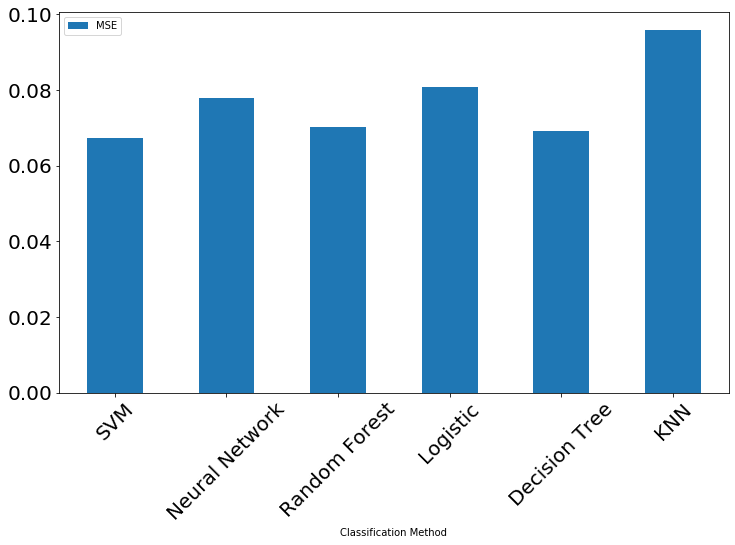

In [86]:
plot_df = pd.DataFrame({'Classification Method':['SVM', 'Neural Network', 'Random Forest',
                                'Logistic', 'Decision Tree', 'KNN'], 
                        'MSE':[abs(rscv.best_score_), 
                               abs(rscv2.best_score_),
                               abs(rscv3.best_score_),
                               abs(rscv4.best_score_),
                               abs(rscv5.best_score_),
                               abs(rscv6.best_score_)]})
plot_df.plot.bar(x='Classification Method', y='MSE', rot=45,figsize=(12,7),fontsize=20)

### map drawing

In [128]:
# higher svmci, better control on corruption

draw_country=ci_output.copy()

In [129]:
dd=draw_country[draw_country['Year']=='2016']

In [130]:
dd

Country Code  Year     SVMCI
20            AGO  2016  0.146210
41            ALB  2016  0.144723
62            ARE  2016  0.568607
83            ARG  2016  0.169881
104           ARM  2016  0.152978
...           ...   ...       ...
2855          YEM  2016  0.169492
2876          ZAF  2016  0.145819
2897          ZAR  2016  0.132367
2918          ZMB  2016  0.187877
2939          ZWE  2016  0.150193

[140 rows x 3 columns]

In [132]:
import folium

country_shapes='/Users/timqzhang/Desktop/UChicago/MACSS_Spring_2020/perspective_local/folium/examples/data/world-countries.json'

f = folium.Figure(width=1000, height=500)
the_map = folium.Map(location=None, width='100%', height='100%', left='0%', top='0%', position='relative', tiles='Mapbox Bright', attr=None, min_zoom=0, max_zoom=18, zoom_start=12, min_lat=- 50, max_lat=90, min_lon=-10, max_lon=150, max_bounds=False, crs='EPSG3857', control_scale=False, prefer_canvas=False, no_touch=False, disable_3d=False, png_enabled=False, zoom_control=False)

the_map.choropleth(
    geo_data=country_shapes,
    name='choropleth',
    data=dd,
    columns=['Country Code', 'SVMCI'],
    key_on='feature.id',
    fill_color='Blues',
    fill_opacity=1,
    line_opacity=1,
    smooth_factor=0.5,
    fill='white',
    bins=[0,0.2, 0.4,0.6, 0.8, 1],
    legend_name='SVM Corruption-Control Index',
    width=0.3
)

the_map

In [133]:
country_name_dict

{'AGO': 'Angola',
 'ALB': 'Albania',
 'ARE': 'United Arab Emirates',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BEL': 'Belgium',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BHS': 'Bahamas, The',
 'BLR': 'Belarus',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRN': 'Brunei Darussalam',
 'BWA': 'Botswana',
 'CAN': 'Canada',
 'CHE': 'Switzerland',
 'CHL': 'Chile',
 'CHN': 'China',
 'CIV': "Côte d'Ivoire",
 'CMR': 'Cameroon',
 'COG': 'Congo, Rep.',
 'COL': 'Colombia',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CYP': 'Cyprus',
 'CZE': 'Czech Republic',
 'DEU': 'Germany',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'EGY': 'Egypt, Arab Rep.',
 'ESP': 'Spain',
 'EST': 'Estonia',
 'ETH': 'Ethiopia',
 'FIN': 'Finland',
 'FRA': 'France',
 'GAB': 'Gabon',
 'GBR': 'United Kingdom',
 'GHA': 'Ghana',
 'GIN': 'Guinea',
 'GMB': 'Gambia, The',
 'GNB': 'Guinea-Bissau'

In [134]:
dd=ci_output[ci_output['Country Code']=='BRA']

In [135]:
ci_output.insert(0, 'Year_str', [str(x) for x in ci_output['Year'].values],True)

In [136]:
ci_output

Year_str Country Code  Year     SVMCI
0        1996          AGO  1996  0.058076
1        1997          AGO  1997  0.127397
2        1998          AGO  1998  0.125610
3        1999          AGO  1999  0.207904
4        2000          AGO  2000  0.146903
...       ...          ...   ...       ...
2935     2012          ZWE  2012  0.142179
2936     2013          ZWE  2013  0.148406
2937     2014          ZWE  2014  0.155365
2938     2015          ZWE  2015  0.148473
2939     2016          ZWE  2016  0.150193

[2940 rows x 4 columns]

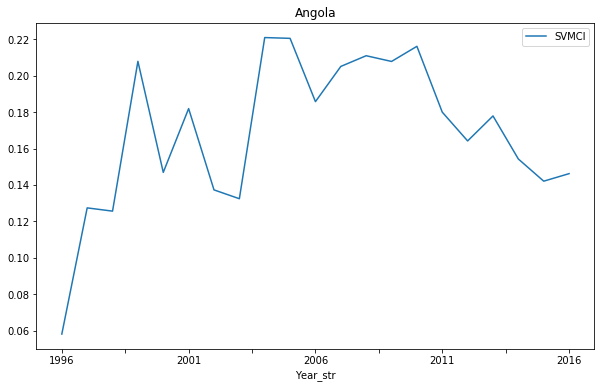

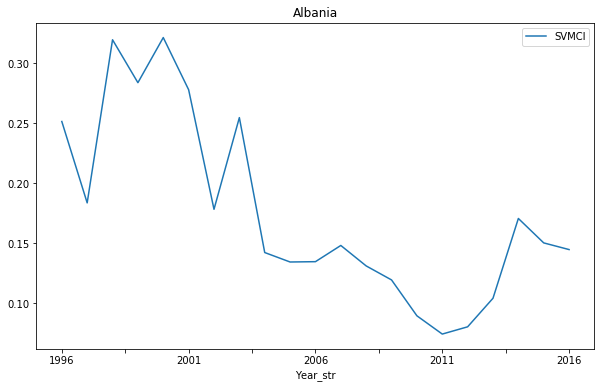

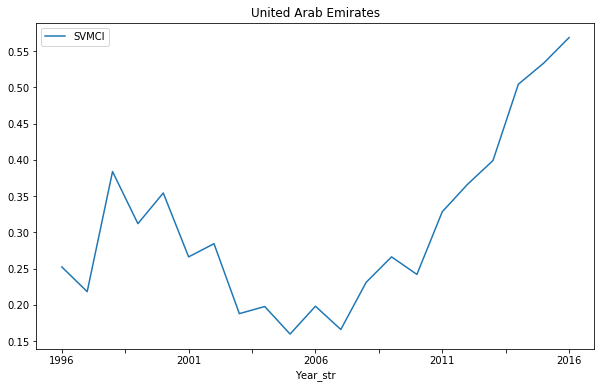

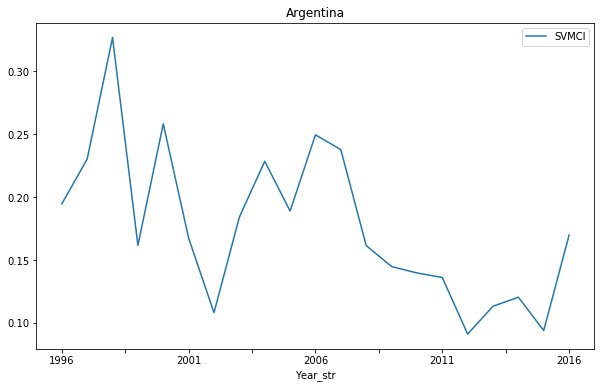

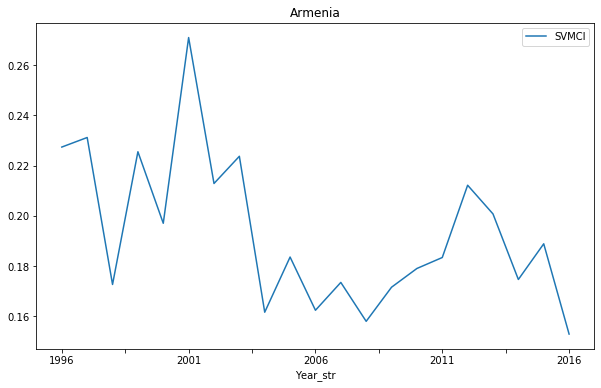

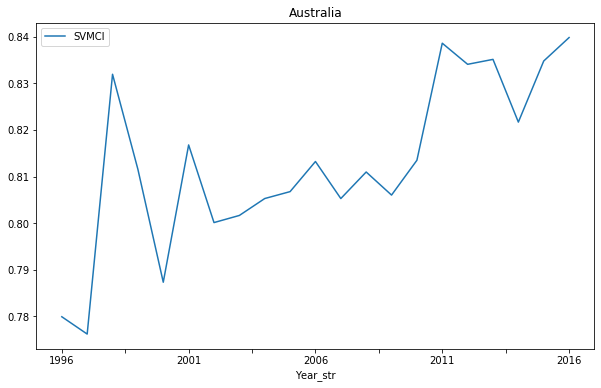

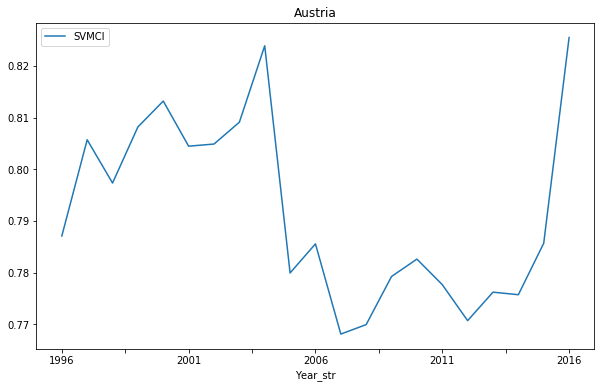

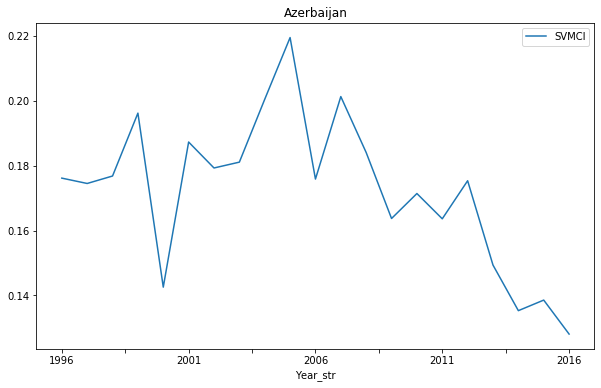

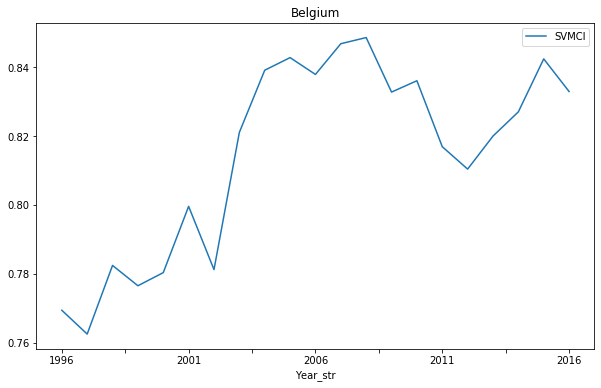

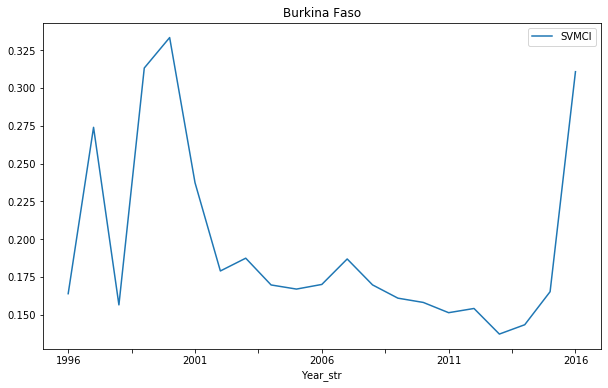

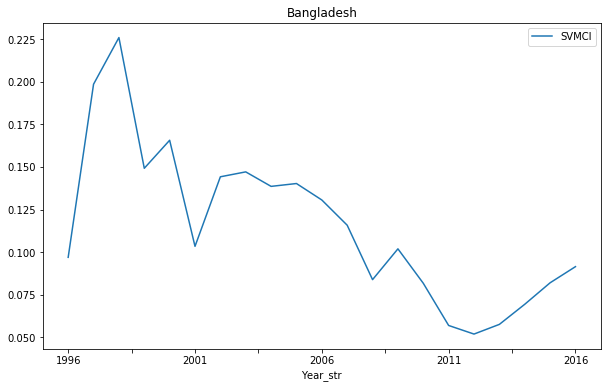

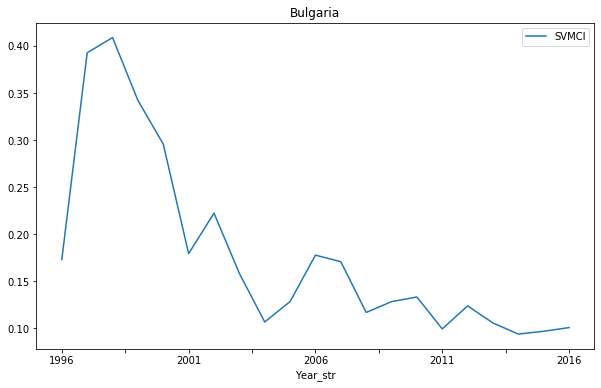

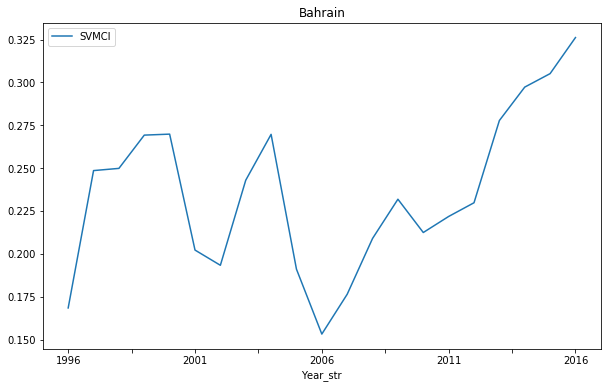

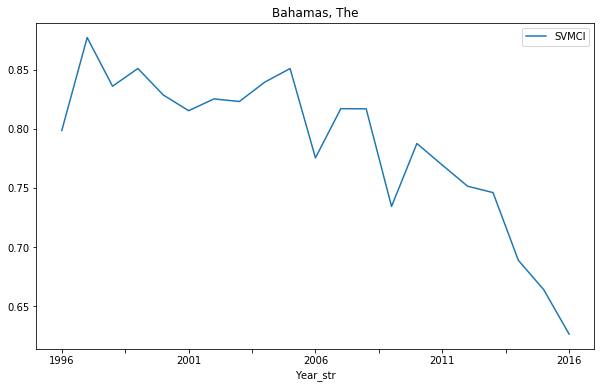

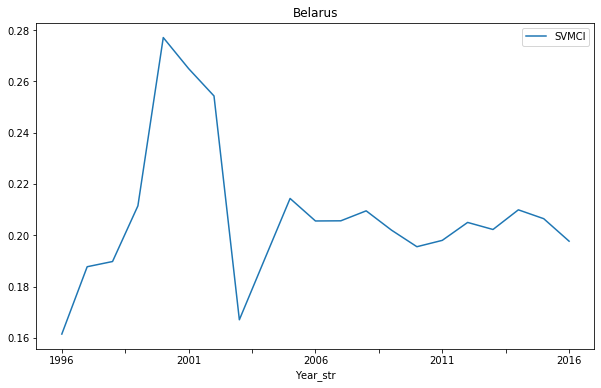

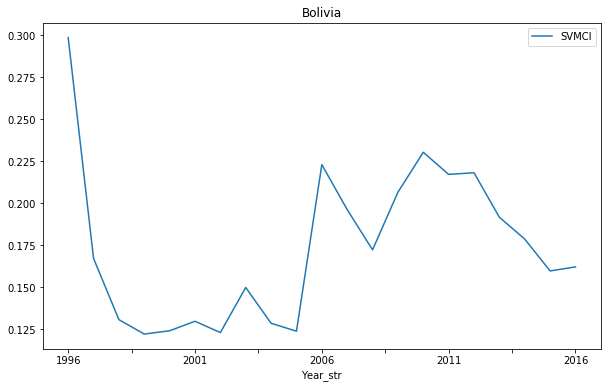

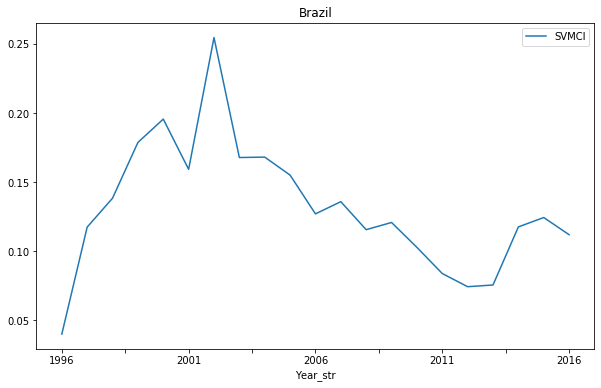

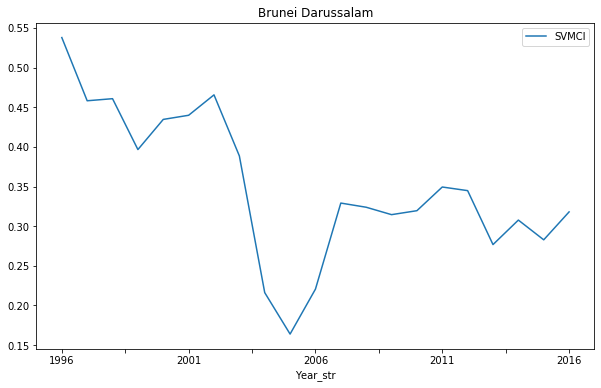

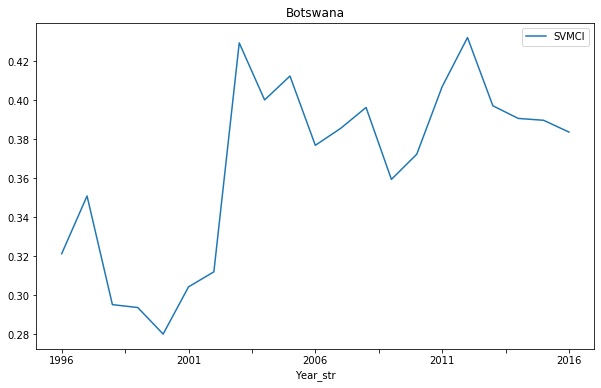

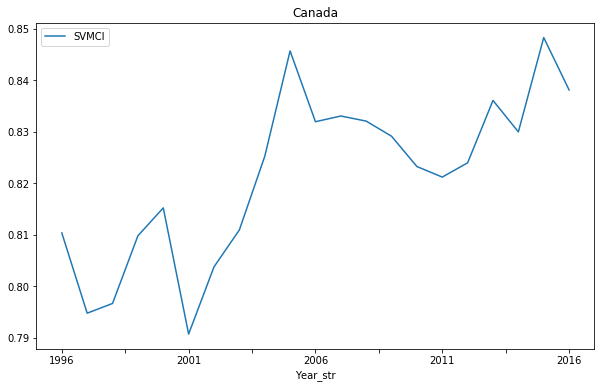

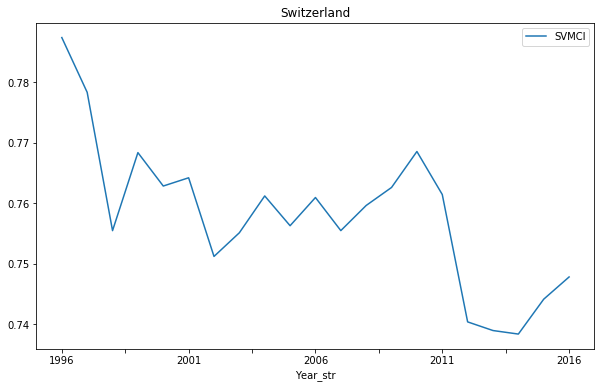

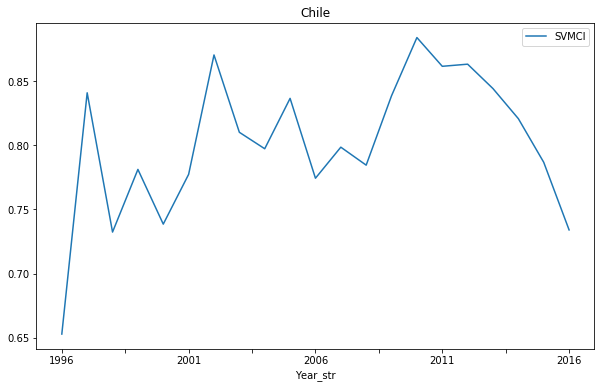

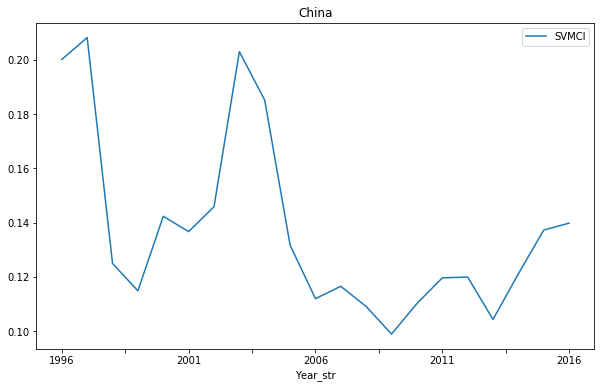

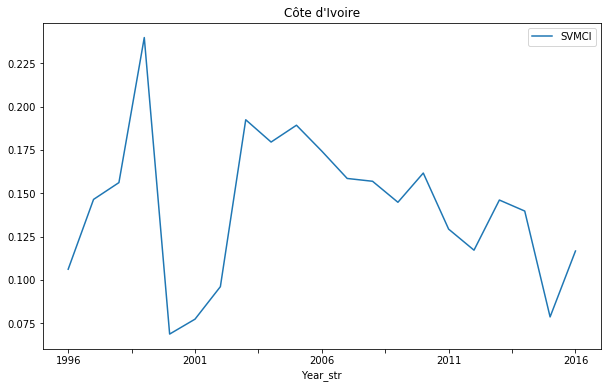

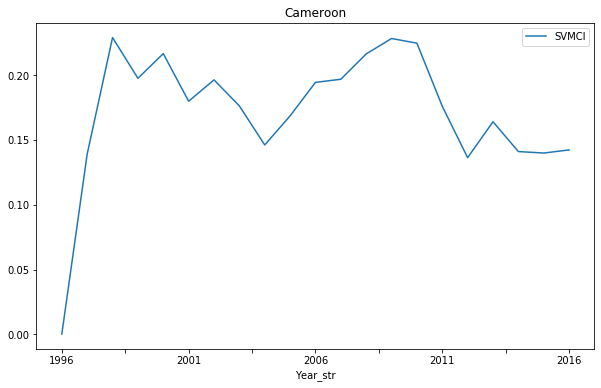

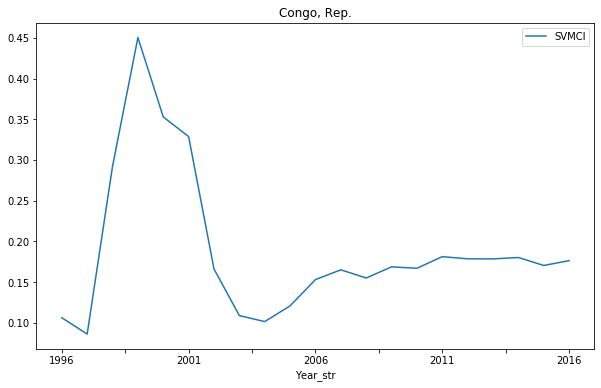

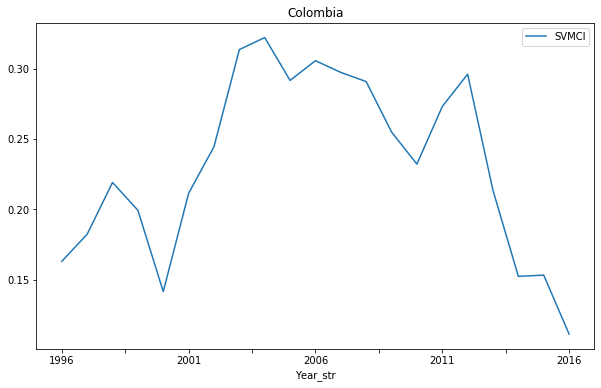

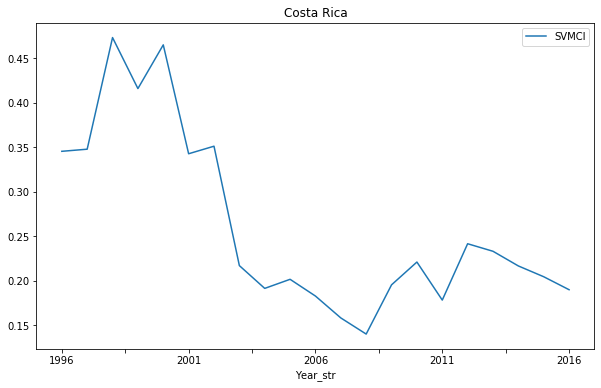

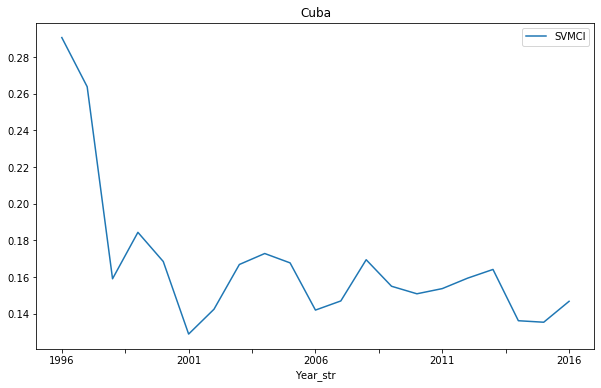

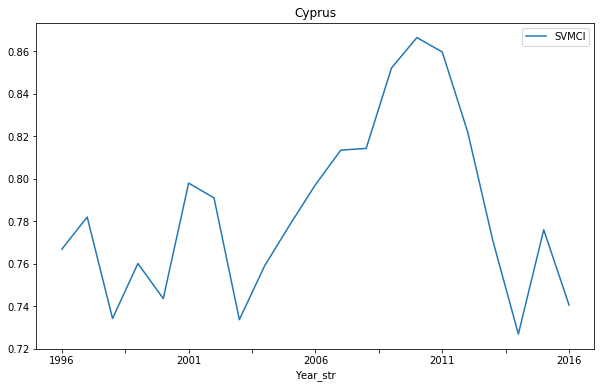

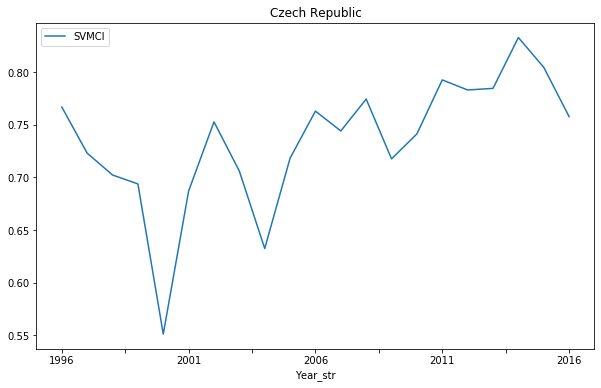

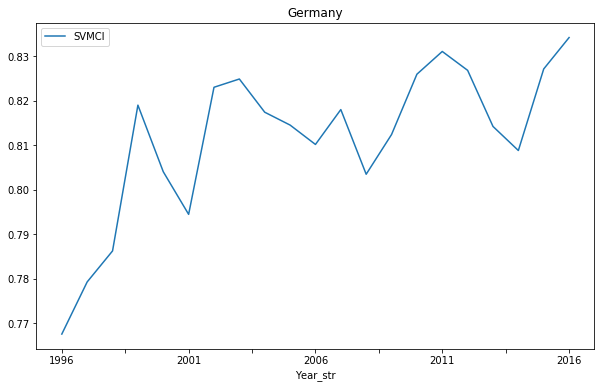

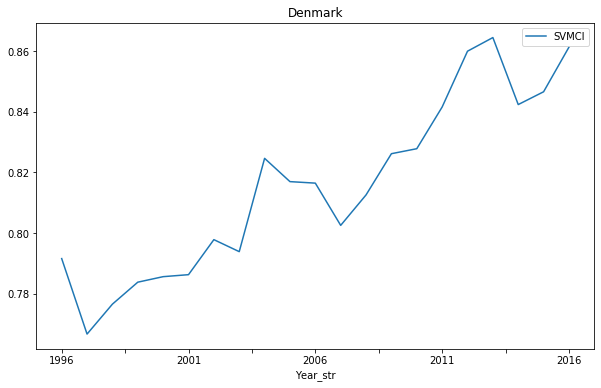

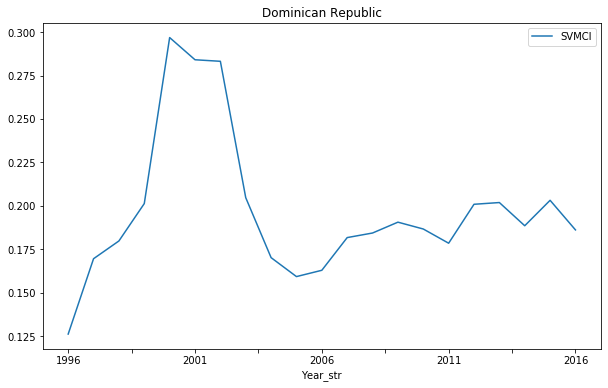

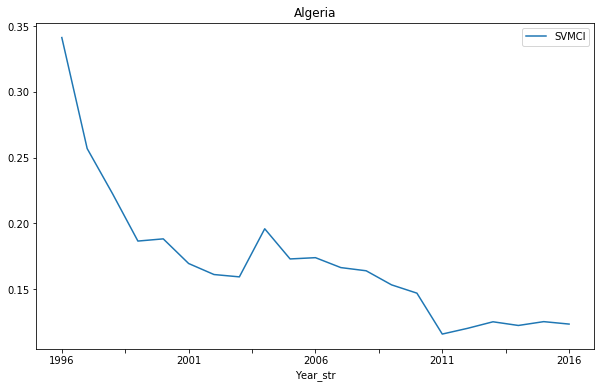

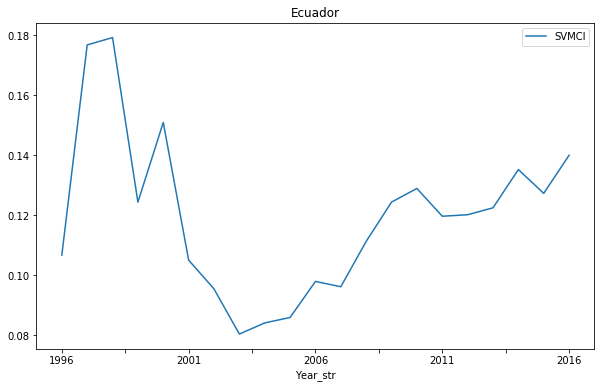

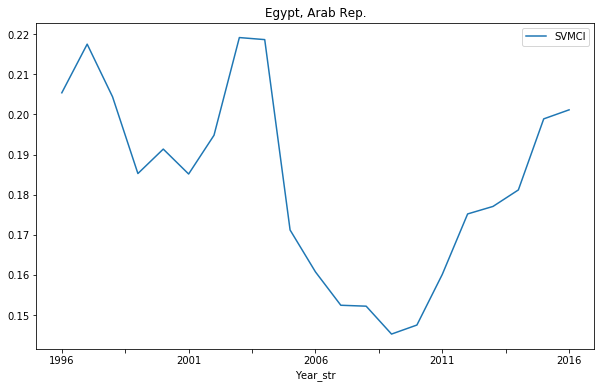

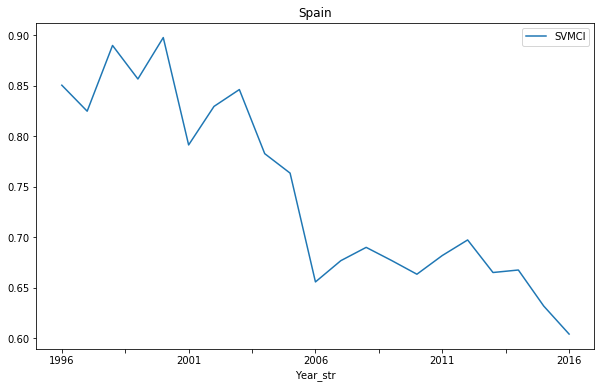

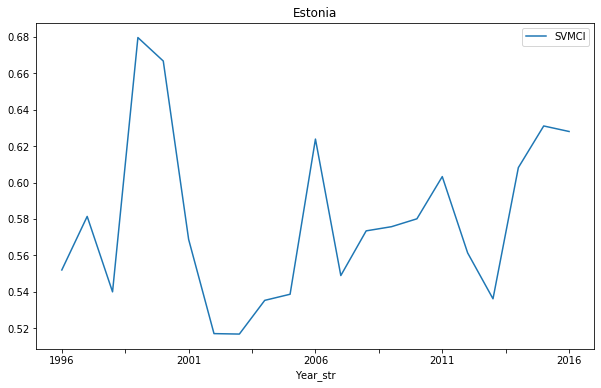

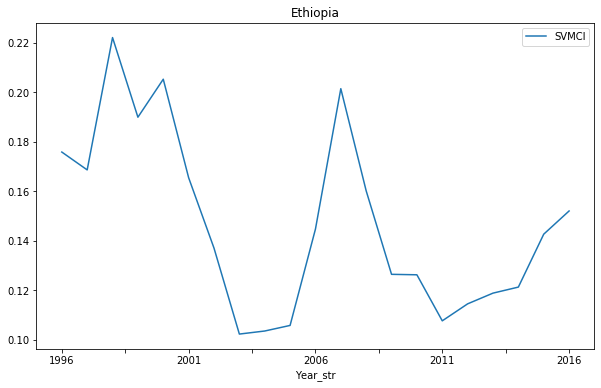

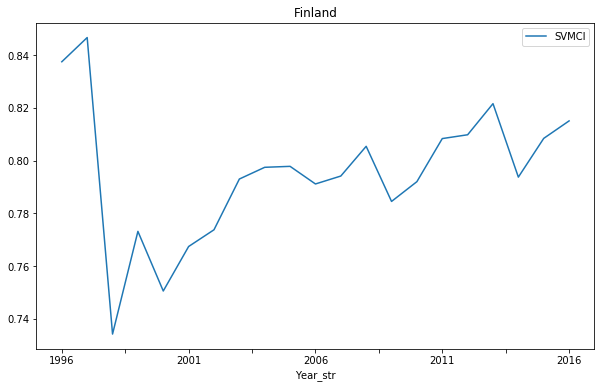

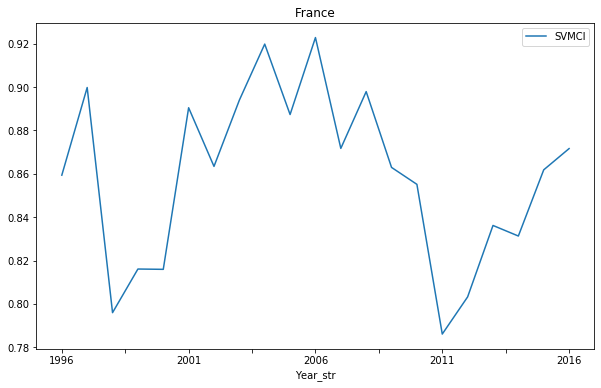

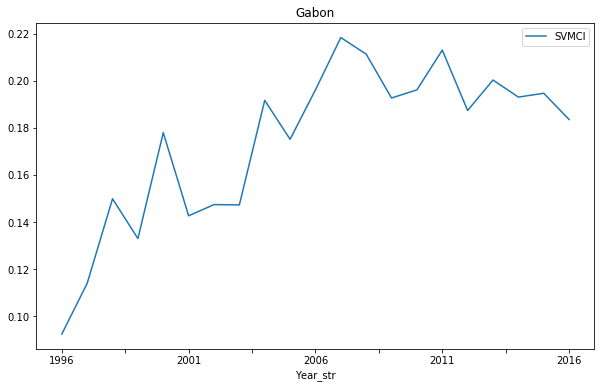

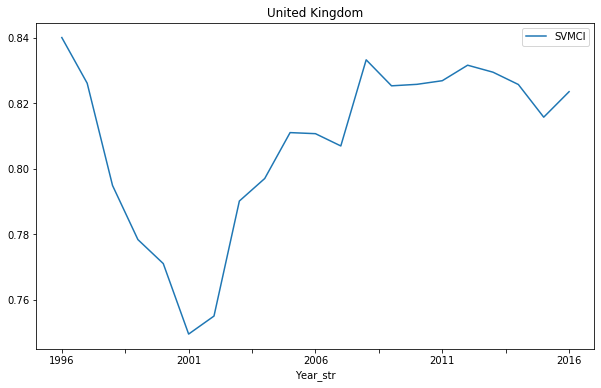

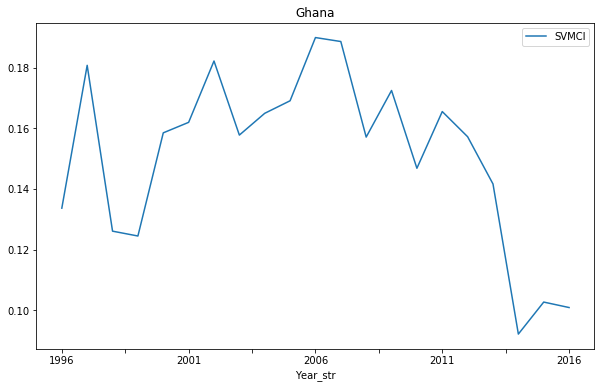

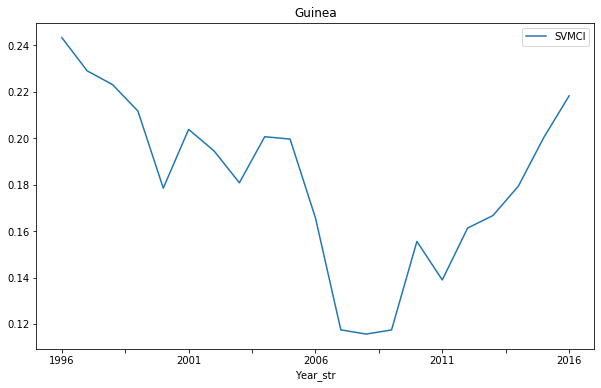

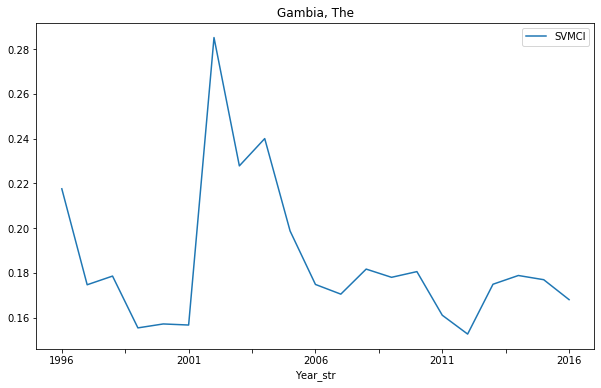

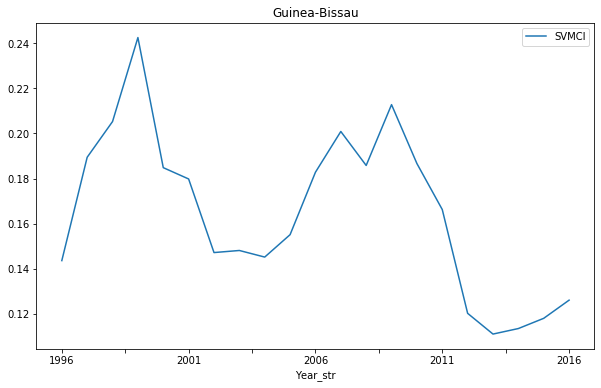

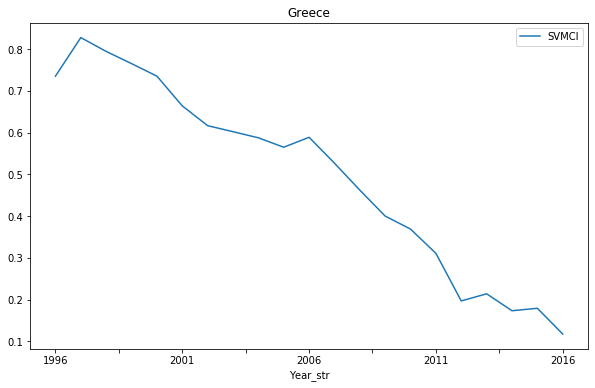

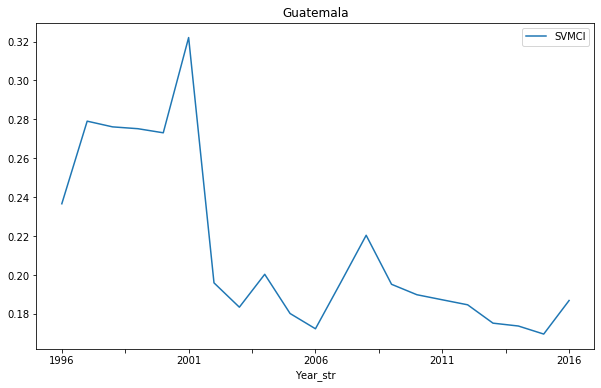

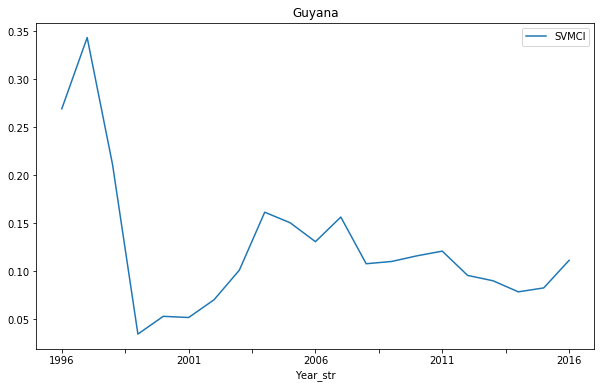

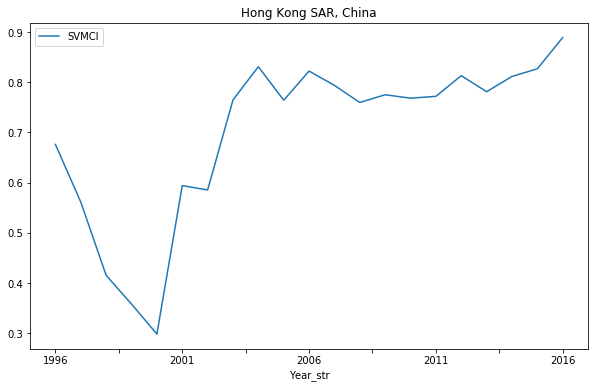

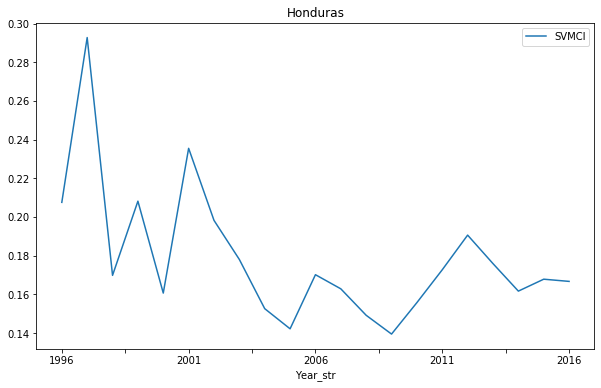

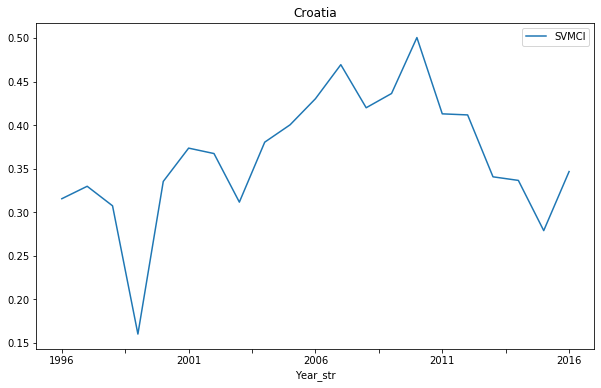

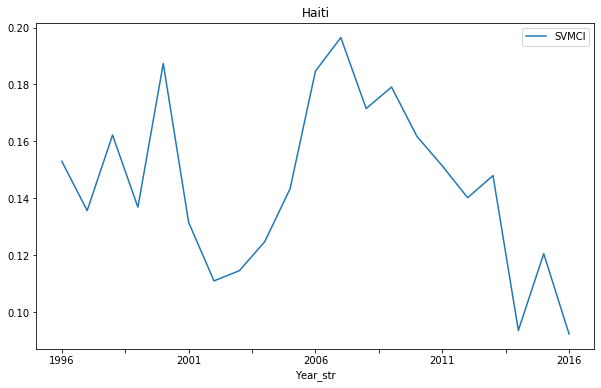

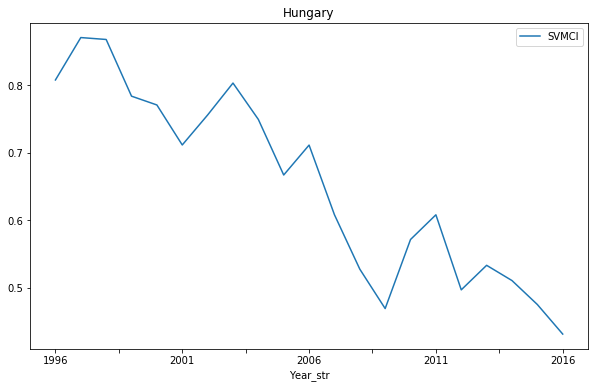

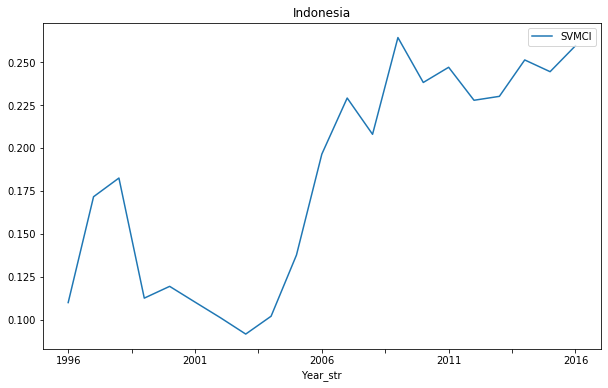

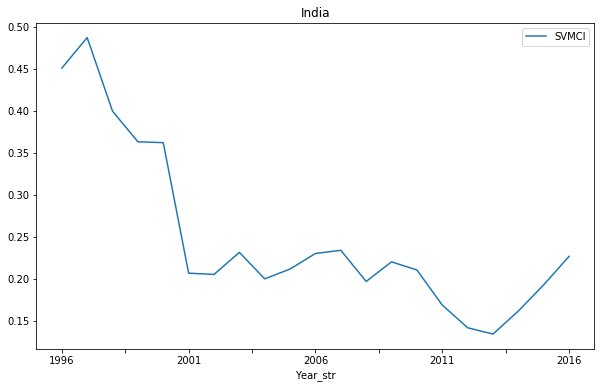

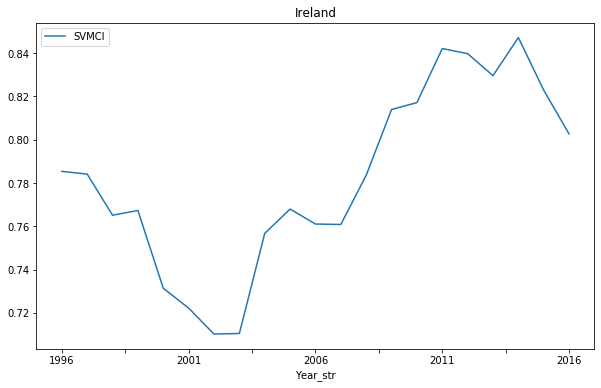

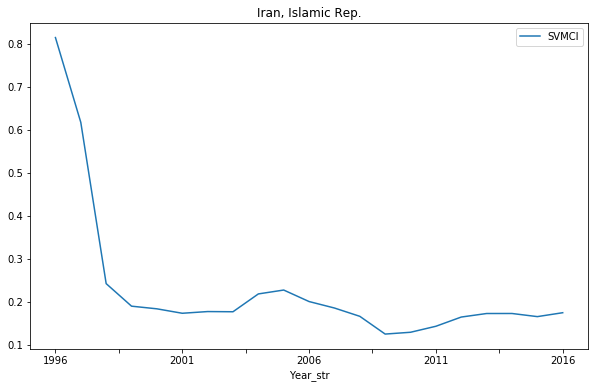

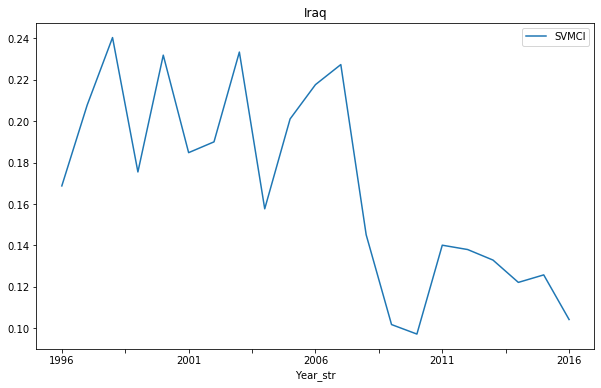

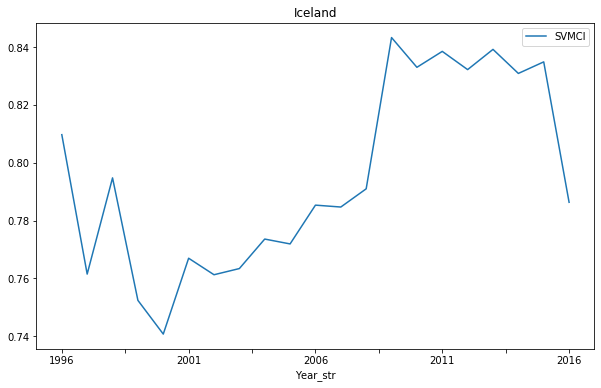

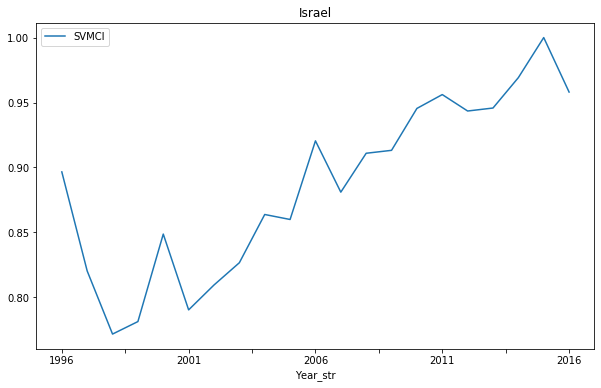

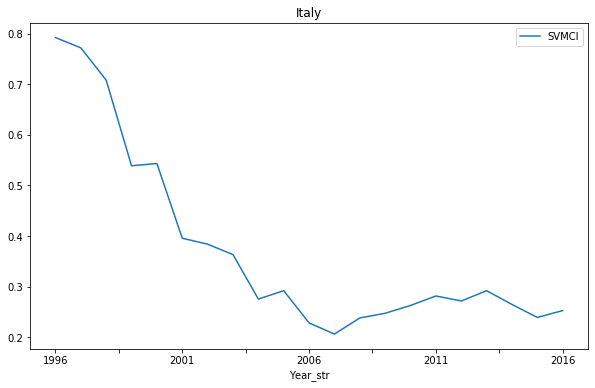

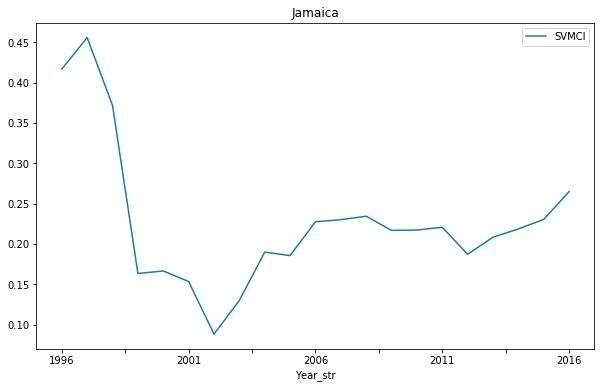

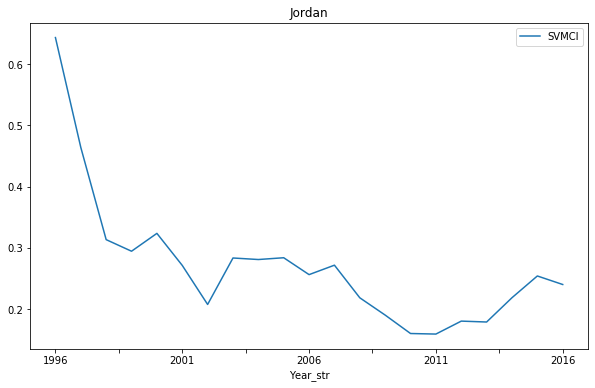

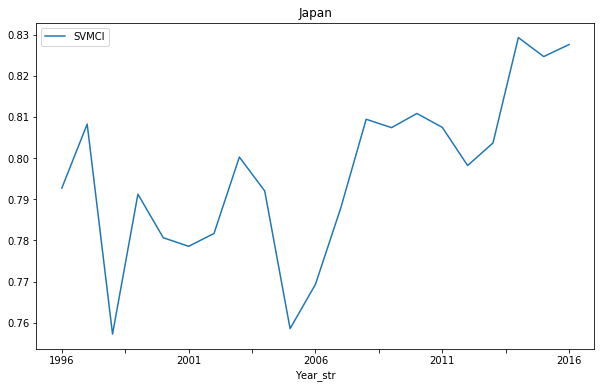

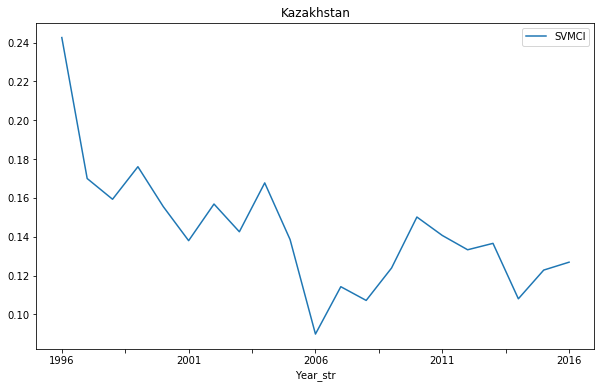

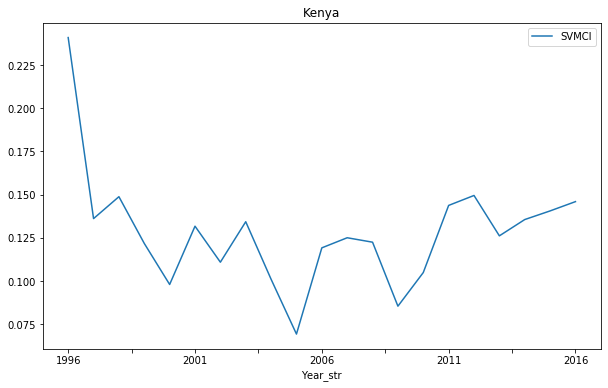

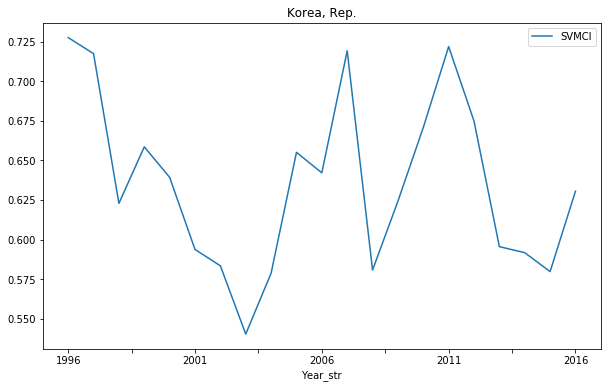

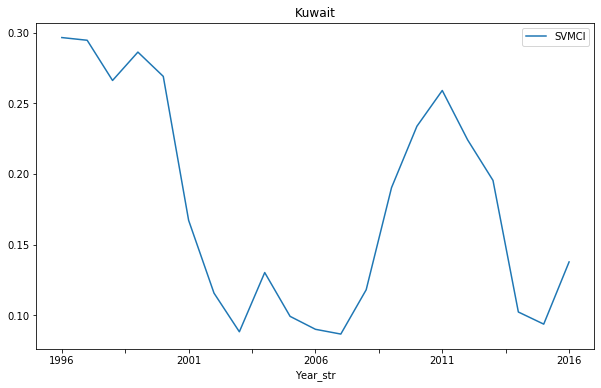

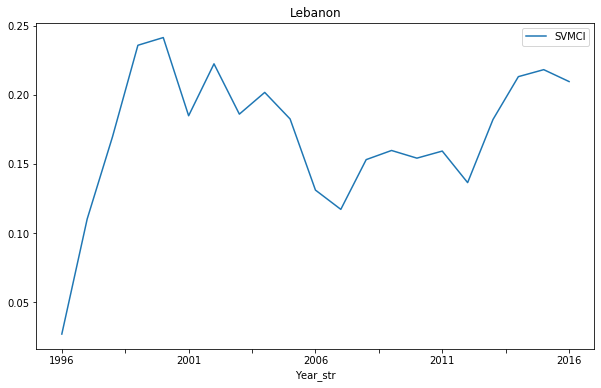

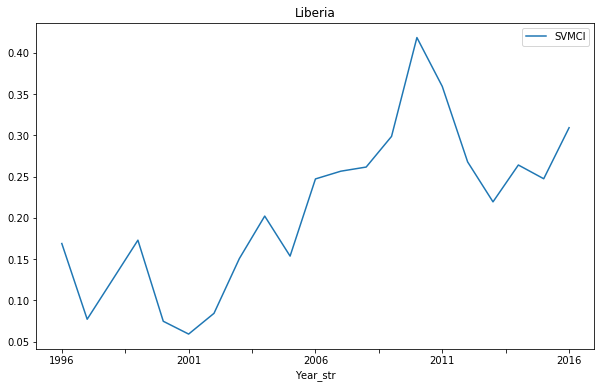

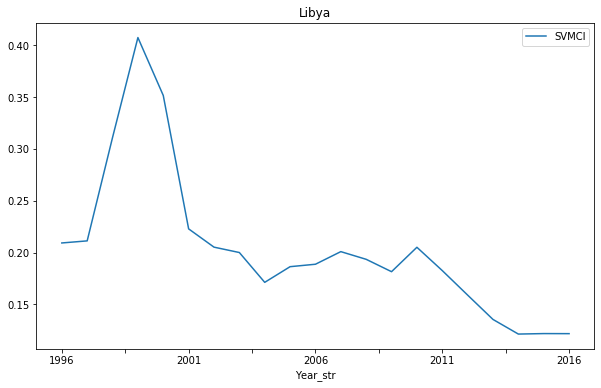

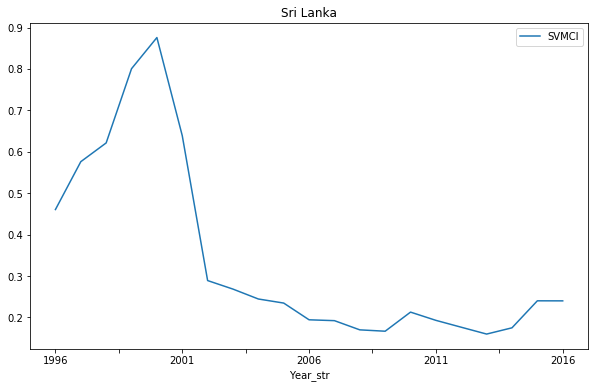

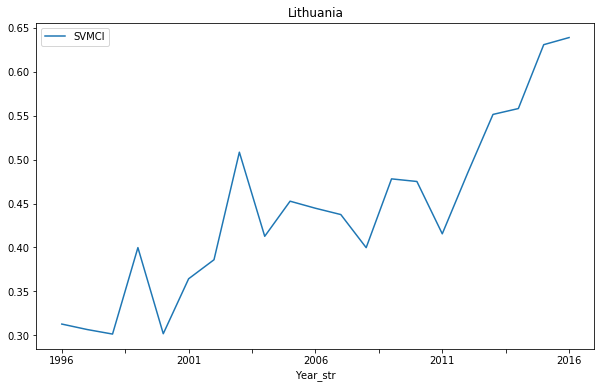

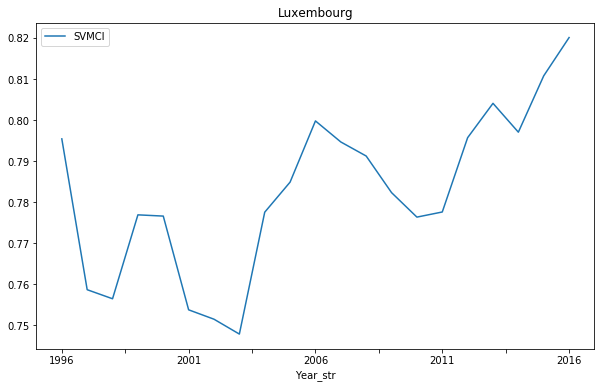

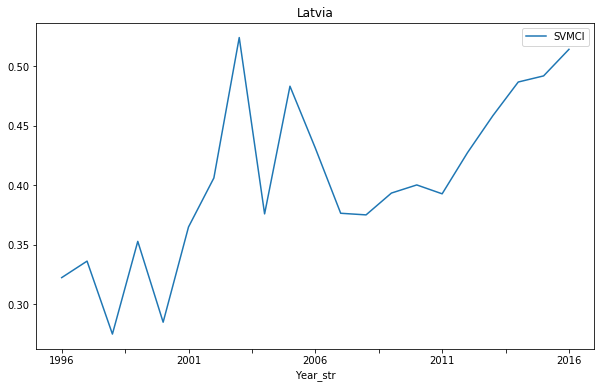

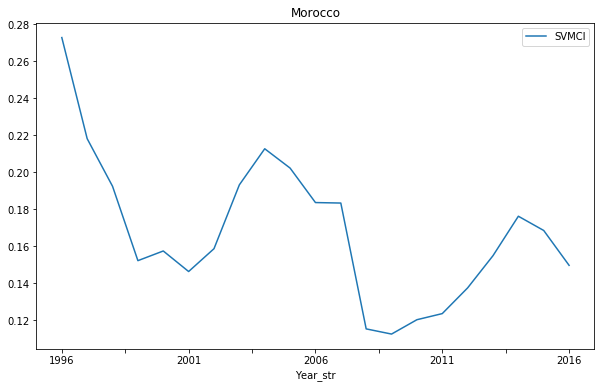

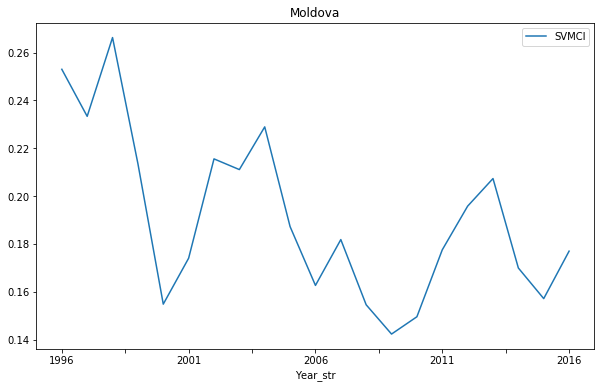

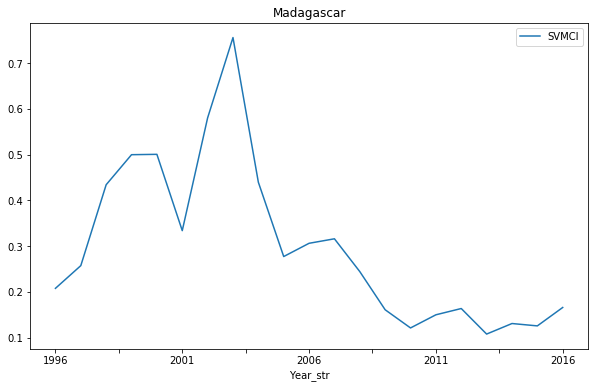

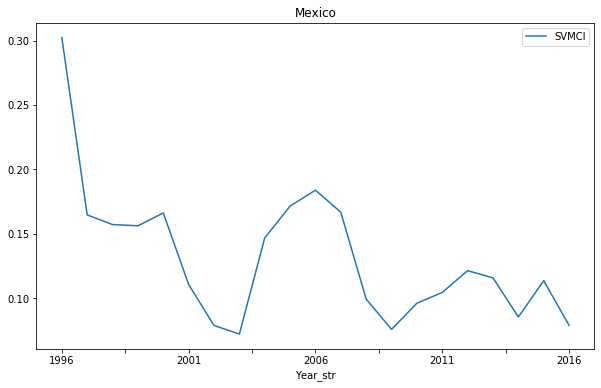

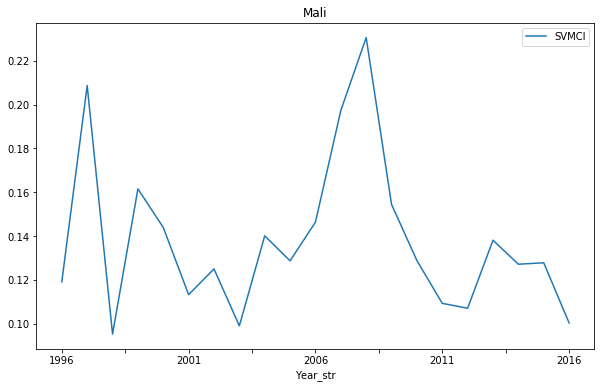

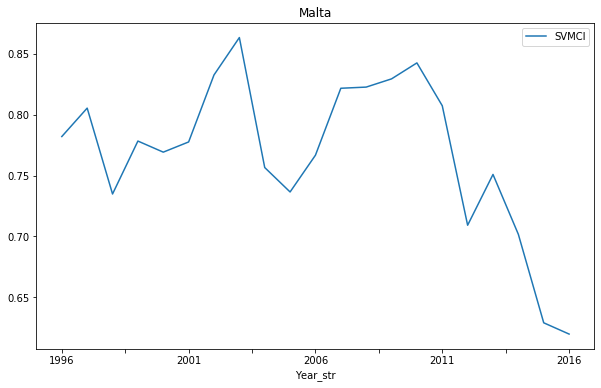

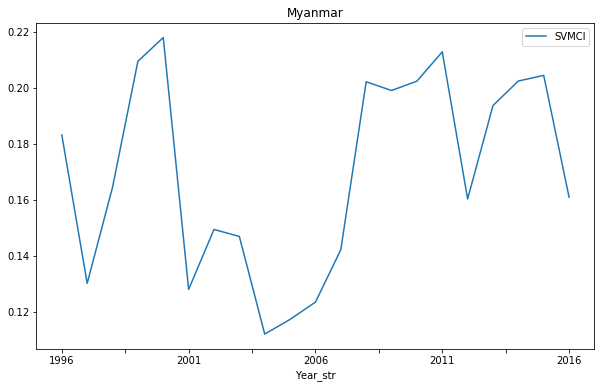

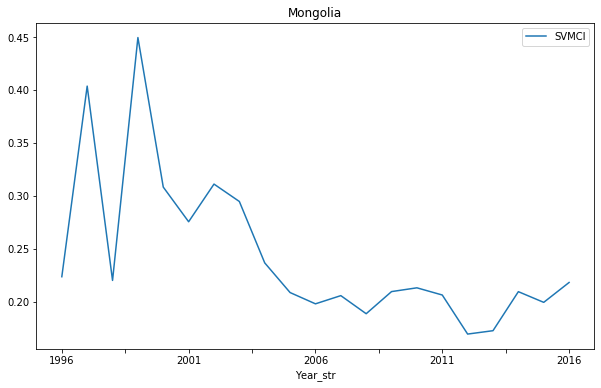

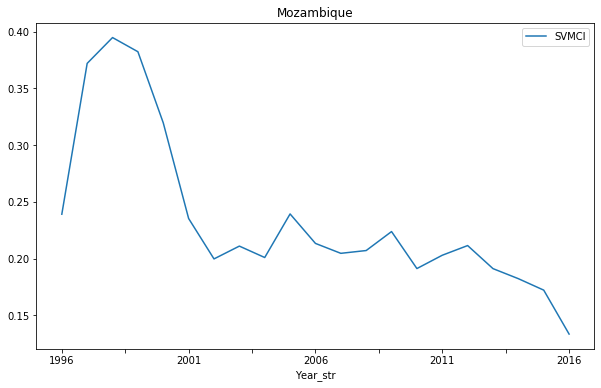

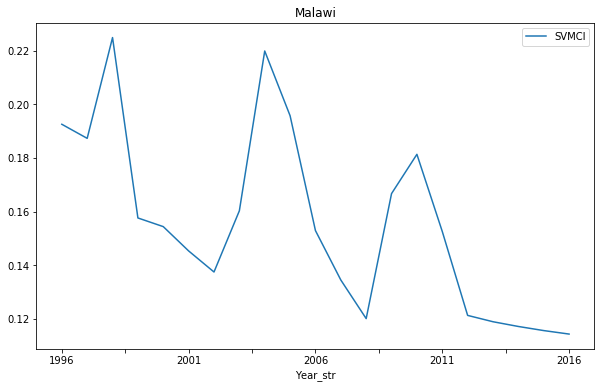

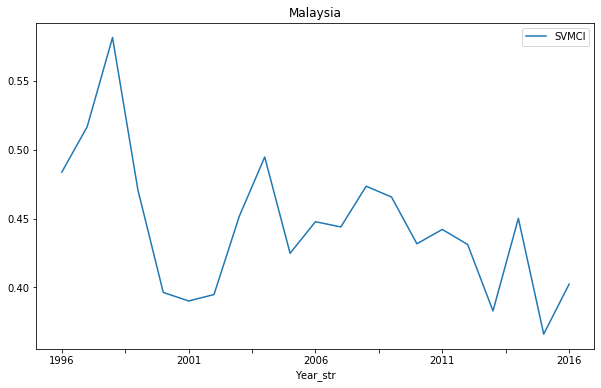

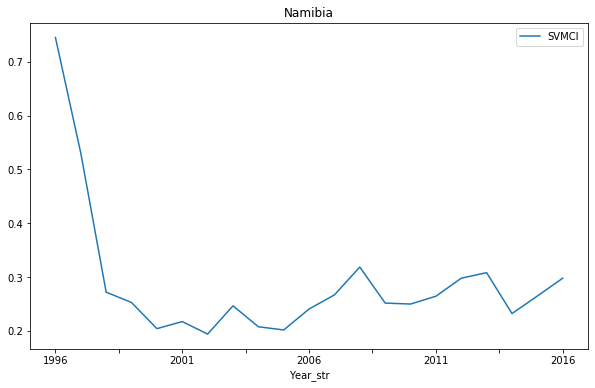

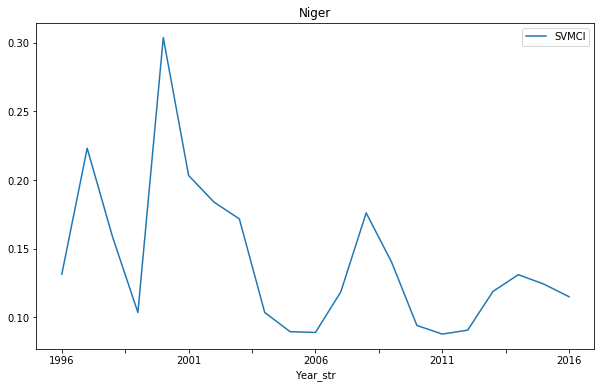

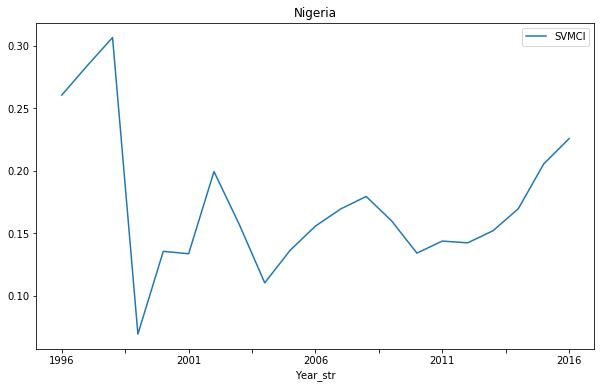

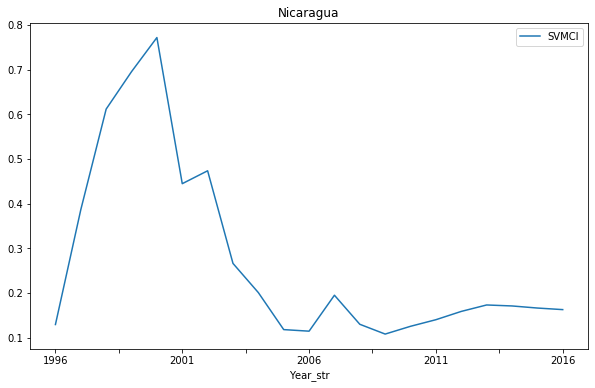

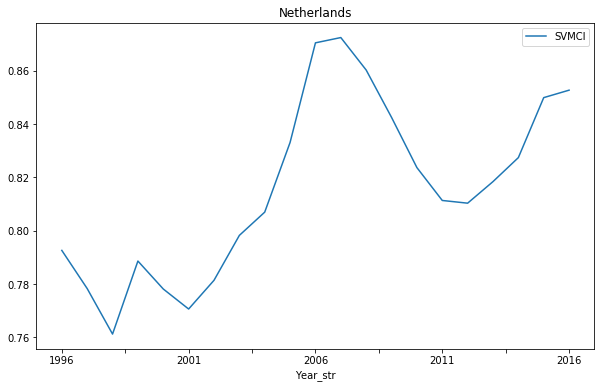

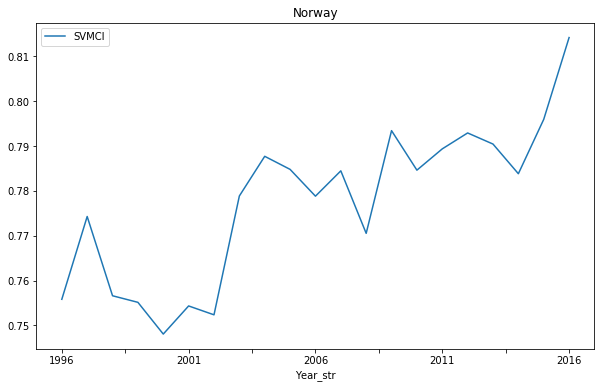

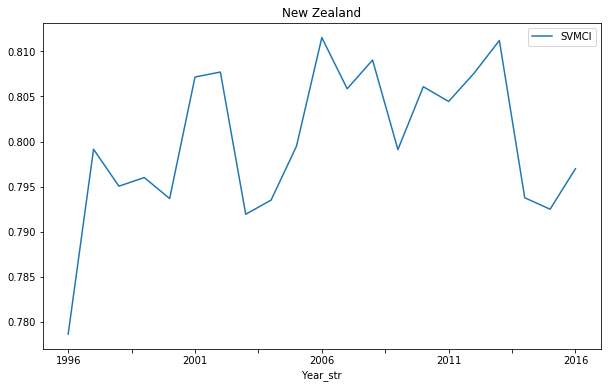

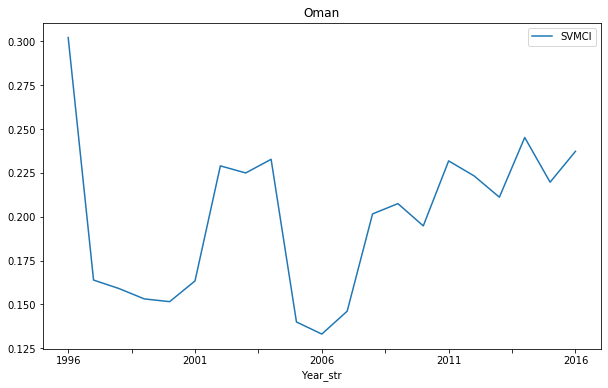

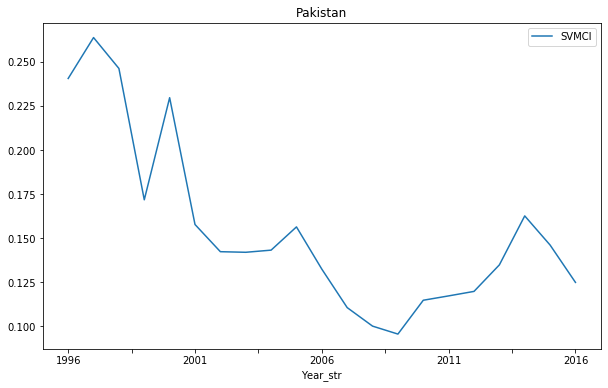

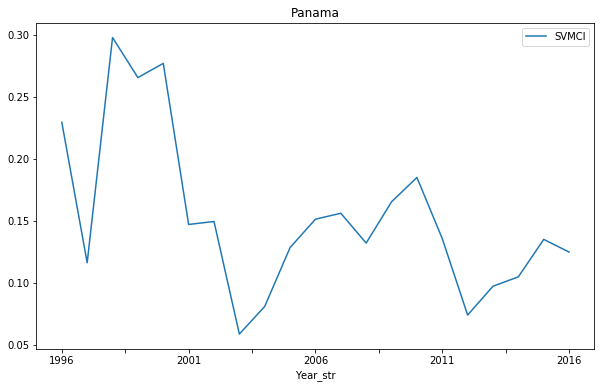

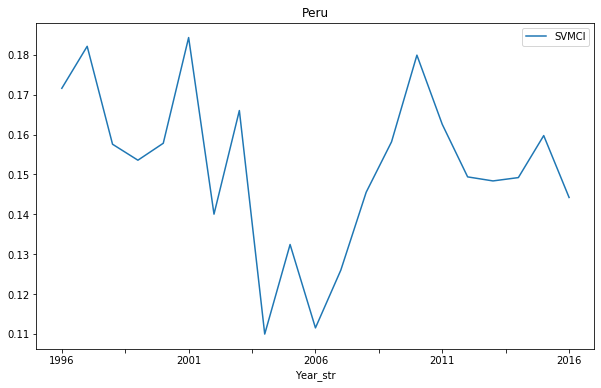

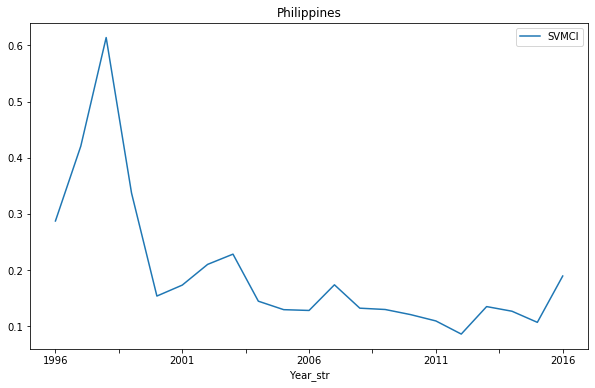

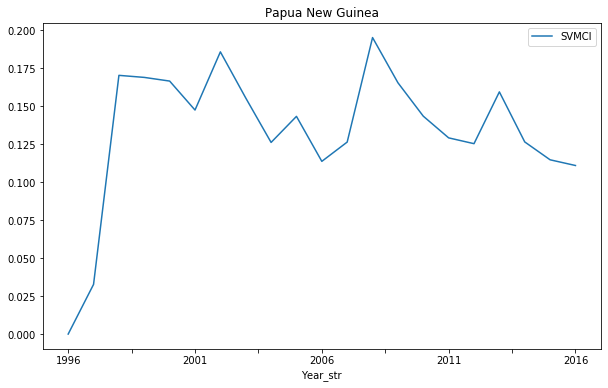

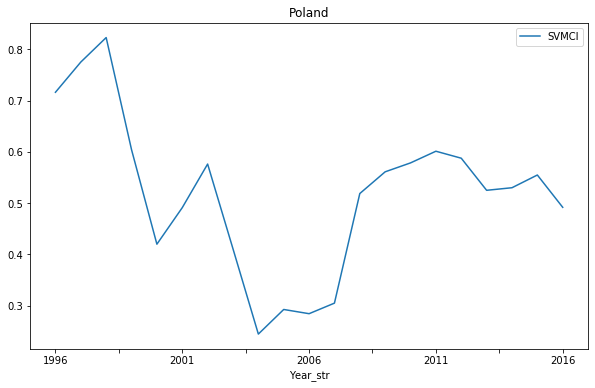

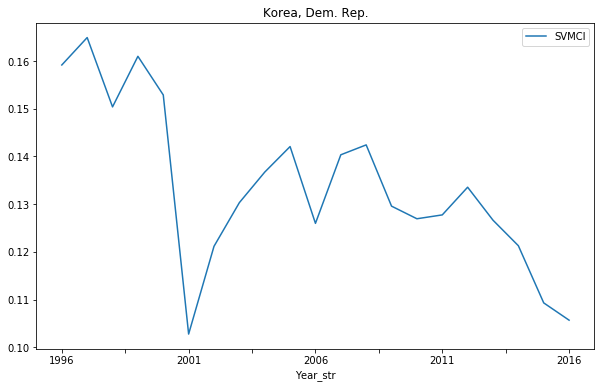

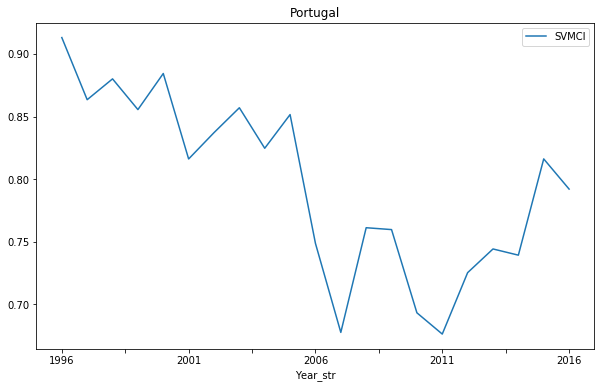

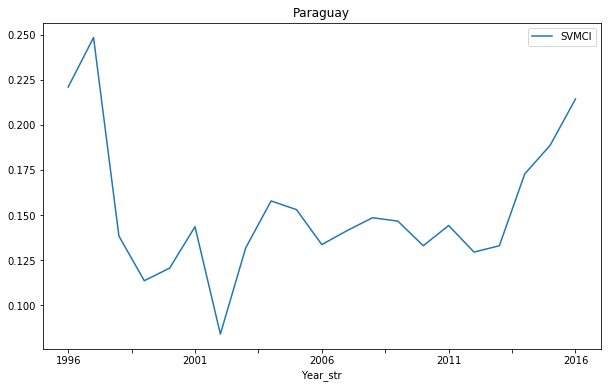

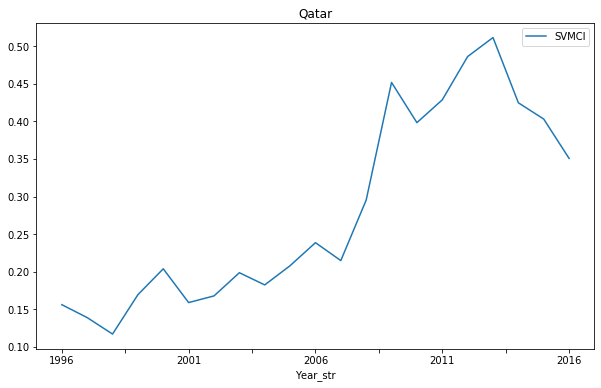

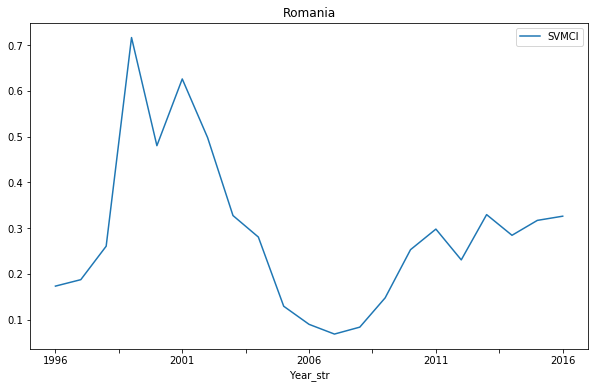

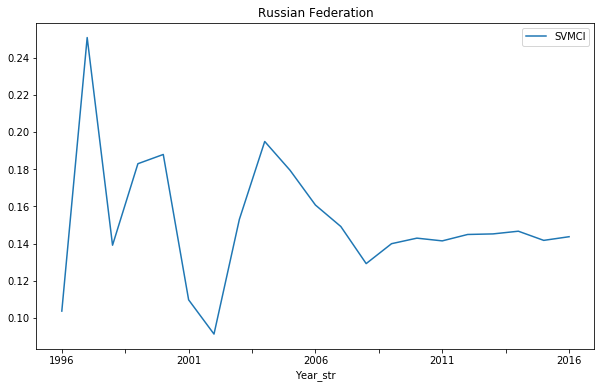

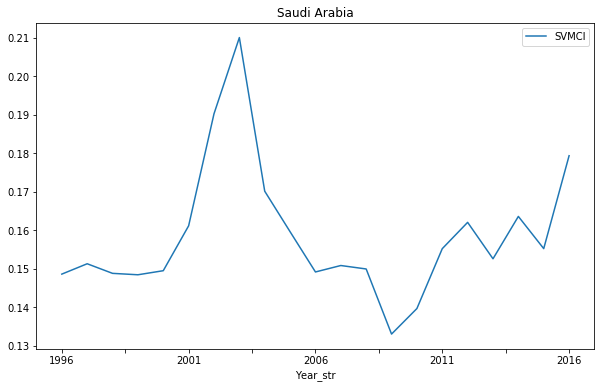

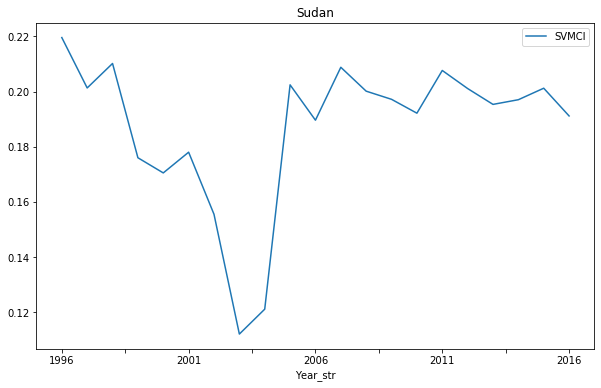

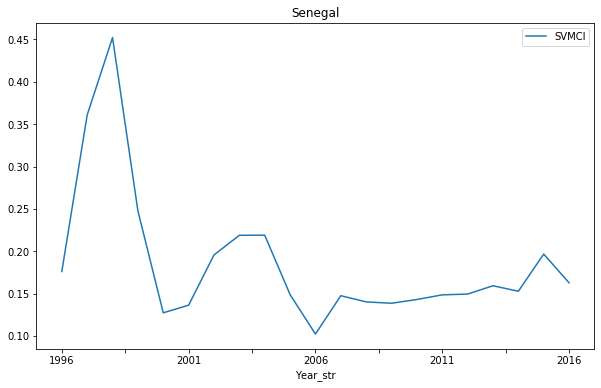

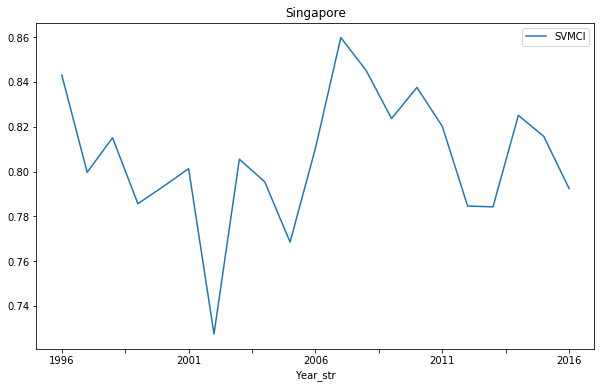

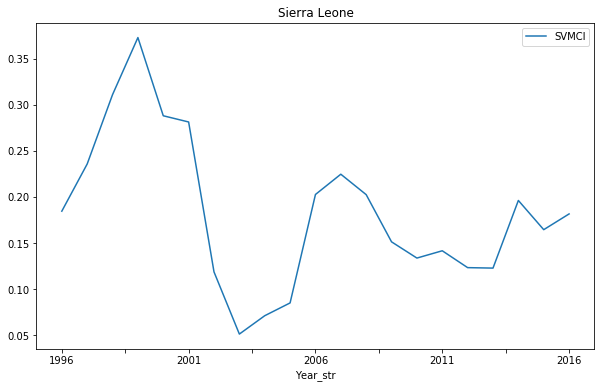

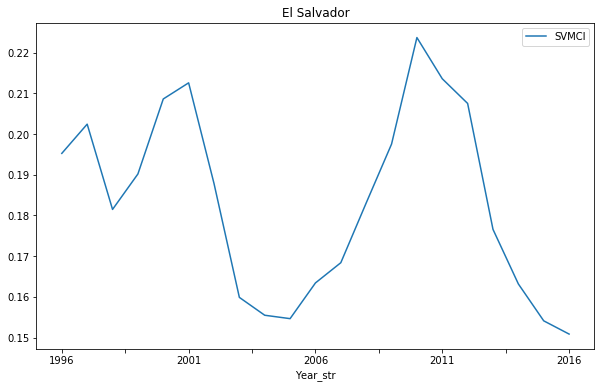

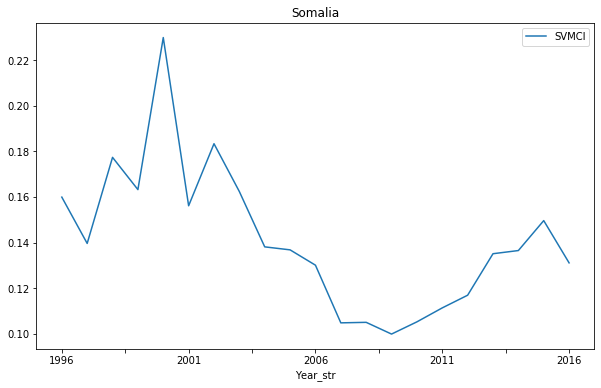

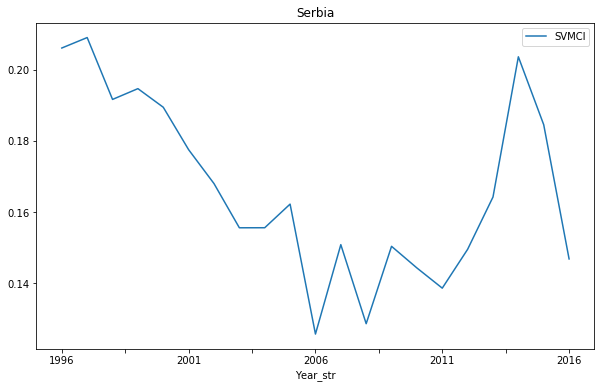

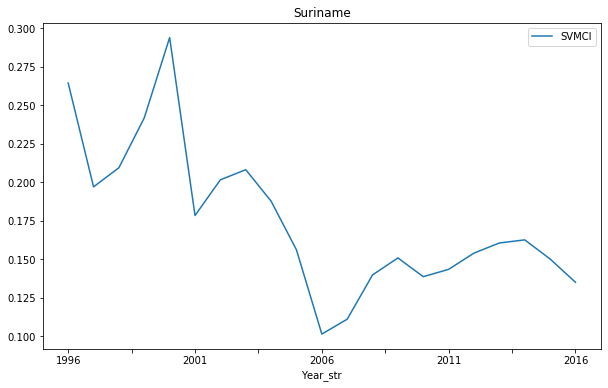

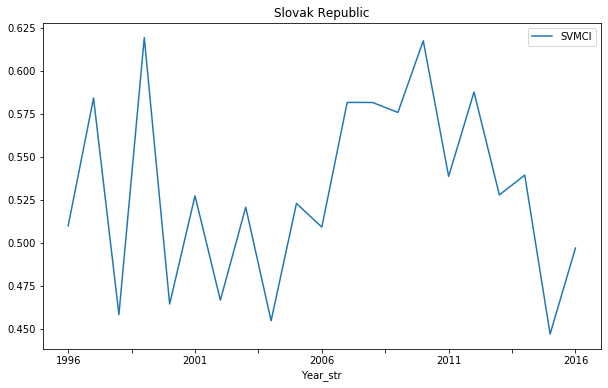

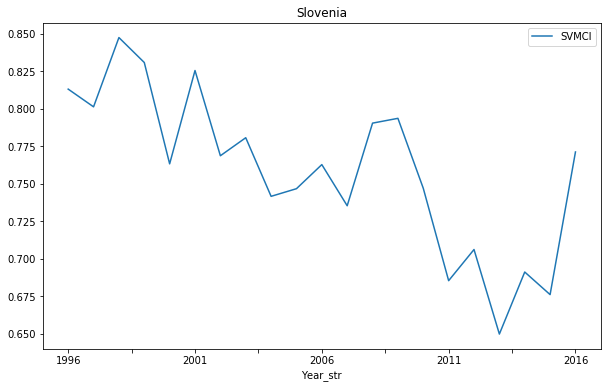

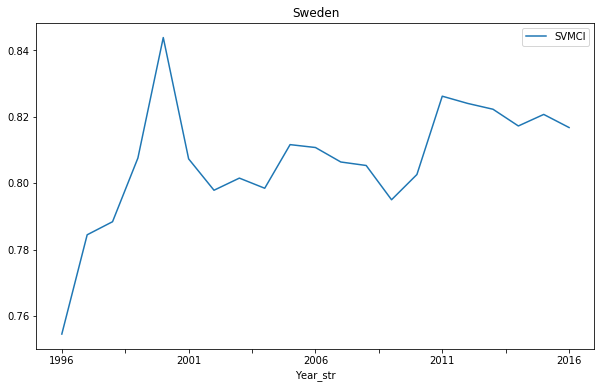

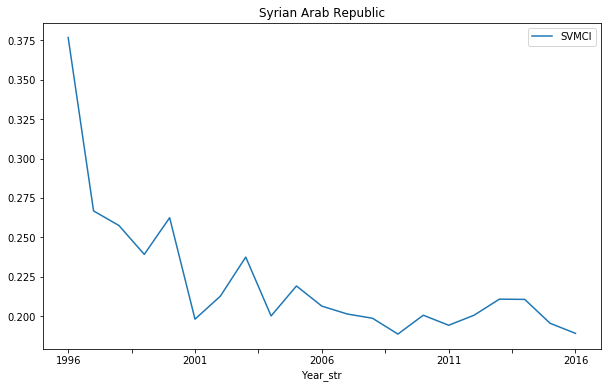

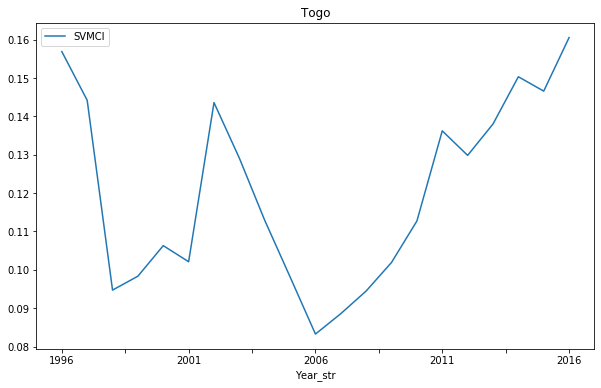

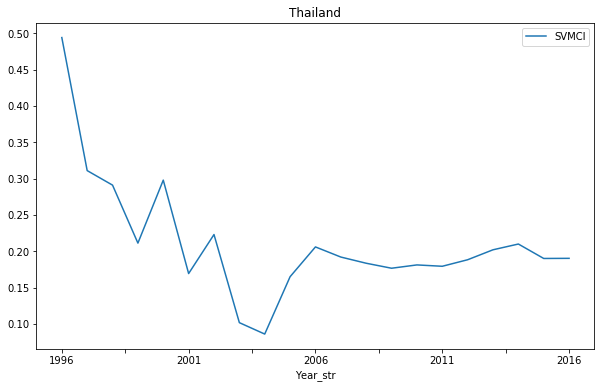

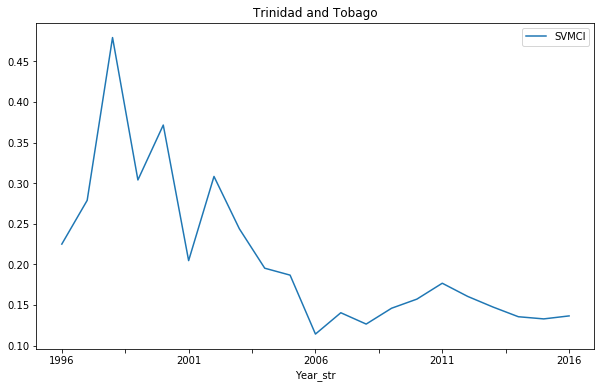

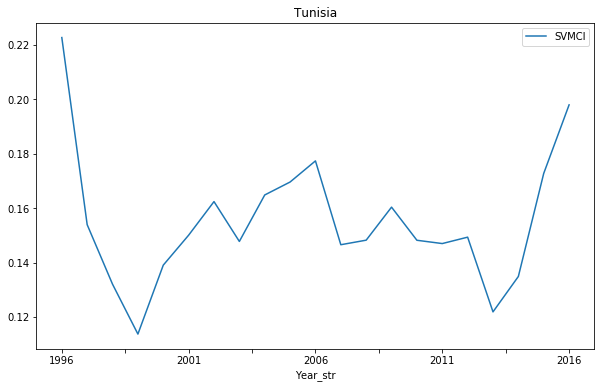

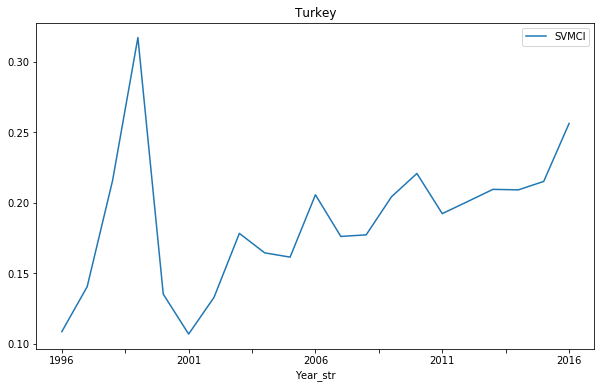

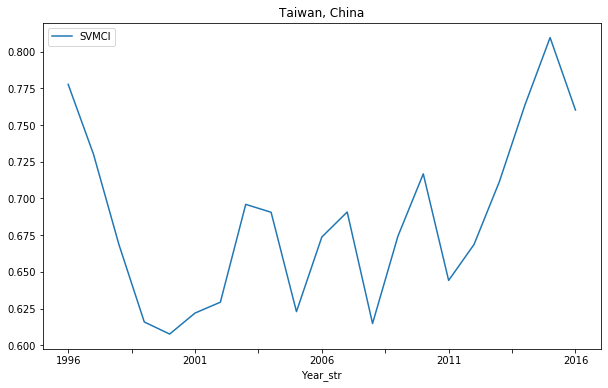

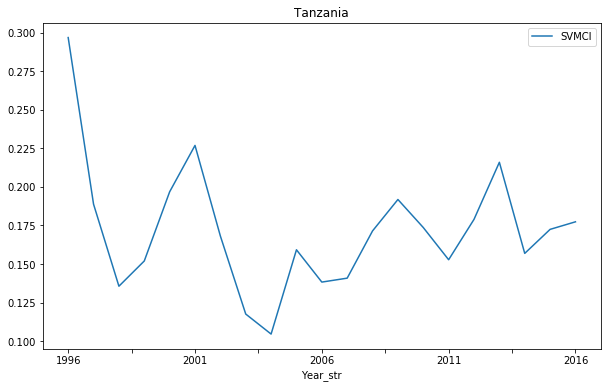

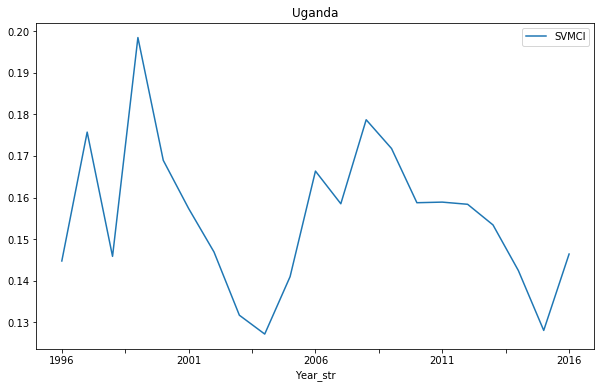

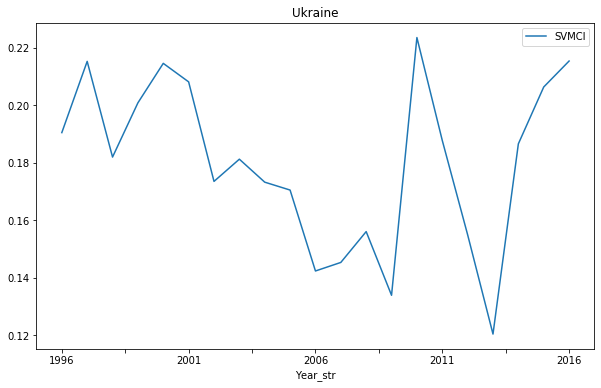

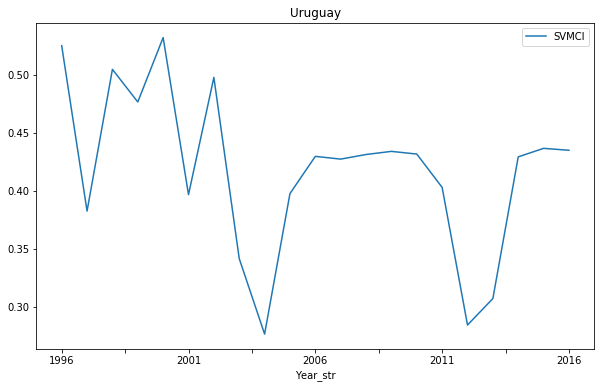

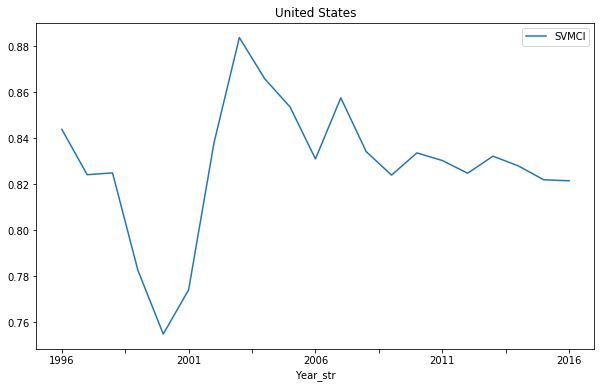

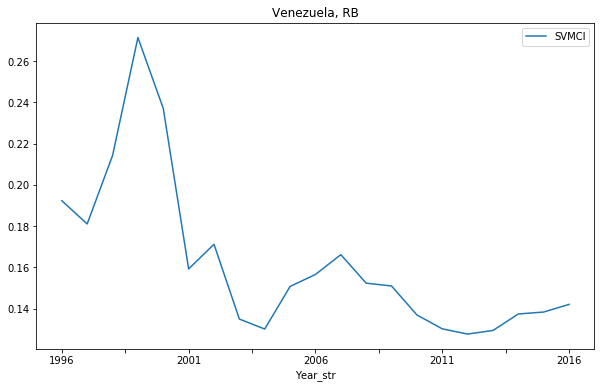

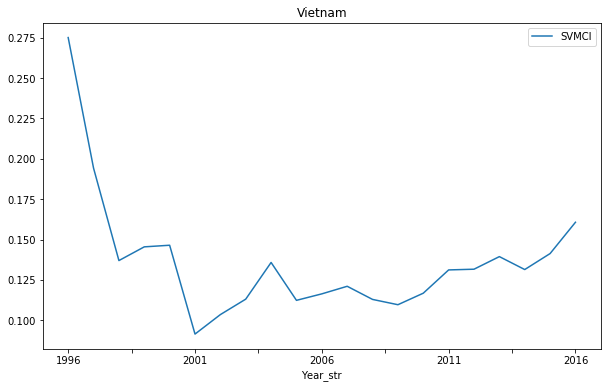

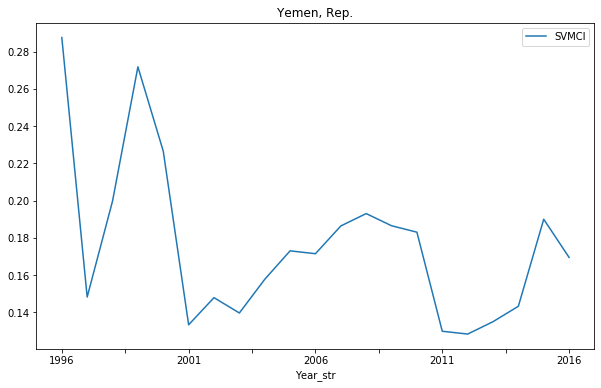

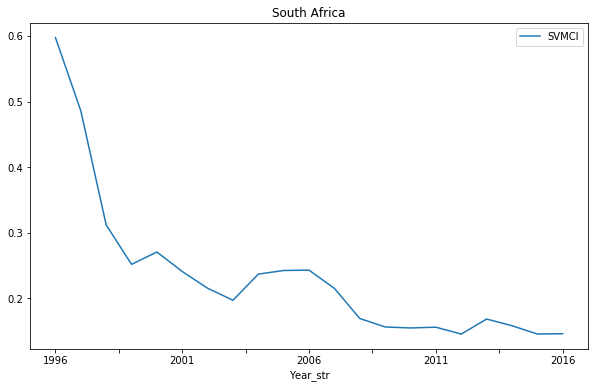

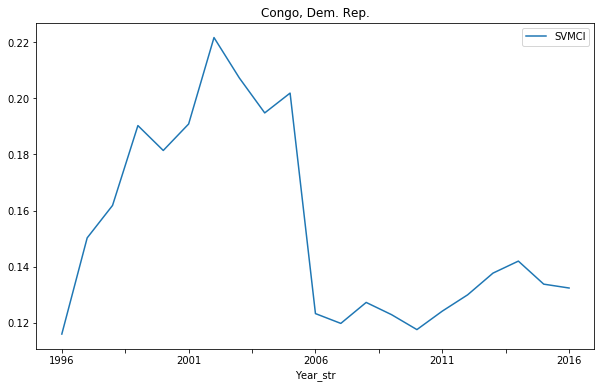

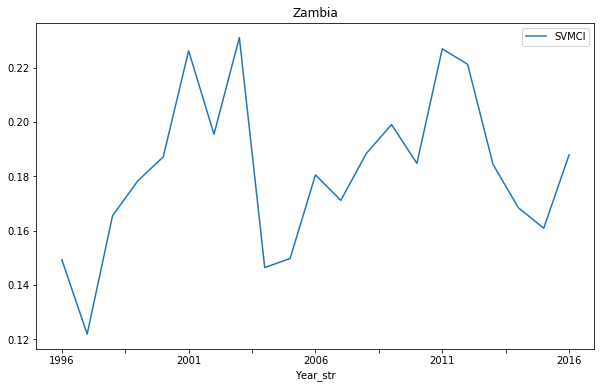

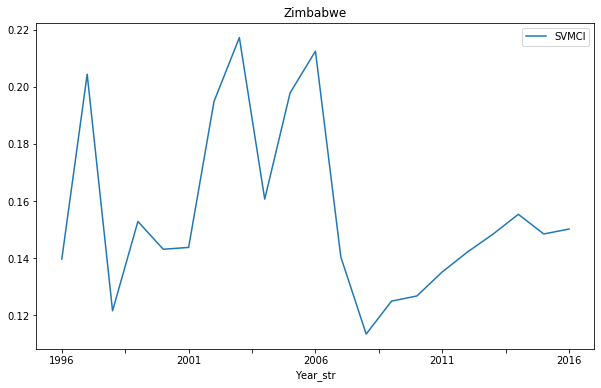

In [137]:
for country in country_name_dict.keys():
    ci_output[ci_output['Country Code']==country].plot(x='Year_str', y='SVMCI', rot=0,figsize=(10,6), title=country_name_dict[country],label='SVMCI')

### kernal fit of distribution

In [138]:
ci_output

Year_str Country Code  Year     SVMCI
0        1996          AGO  1996  0.058076
1        1997          AGO  1997  0.127397
2        1998          AGO  1998  0.125610
3        1999          AGO  1999  0.207904
4        2000          AGO  2000  0.146903
...       ...          ...   ...       ...
2935     2012          ZWE  2012  0.142179
2936     2013          ZWE  2013  0.148406
2937     2014          ZWE  2014  0.155365
2938     2015          ZWE  2015  0.148473
2939     2016          ZWE  2016  0.150193

[2940 rows x 4 columns]

In [139]:
ci_1996=ci_output[ci_output['Year']=='1996']

In [140]:
ci_1996v=ci_1996['SVMCI'].values

Text(0.5, 1.0, 'Histogram of SVM corruption index')

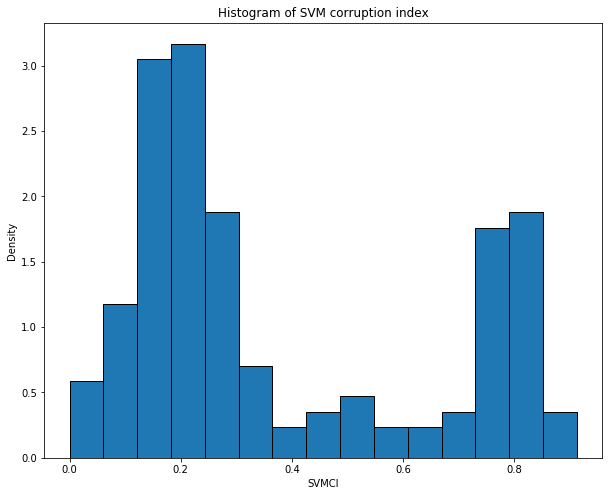

In [141]:
# plot the full sample hist

plt.figure(figsize=(10,8))
n_tot,bin_cuts,patches = plt.hist (ci_1996v, 15, density=True, edgecolor='black')
plt.xlabel('SVMCI')
plt.ylabel('Density')
plt.title('Histogram of SVM corruption index')

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 1000)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())


grid.fit(ci_1996v.reshape((140,1)))
band_1996=grid.best_params_["bandwidth"]

In [143]:
print(band_1996)

0.1


In [144]:
# prepare the plot

x_pts=np.linspace(0,1,1000).reshape((1000,1))

# 1996

ci_1996_kde=KernelDensity(bandwidth=band_1996,kernel='gaussian')
ci_1996_kde.fit(ci_1996v.reshape((140,1)))
fit_1996=ci_1996_kde.score_samples(x_pts).reshape((1000,1))

In [145]:
ci_2016=ci_output[ci_output['Year']=='2016']

In [146]:
ci_2016v=ci_2016['SVMCI'].values

Text(0.5, 1.0, 'Histogram of SVM corruption index')

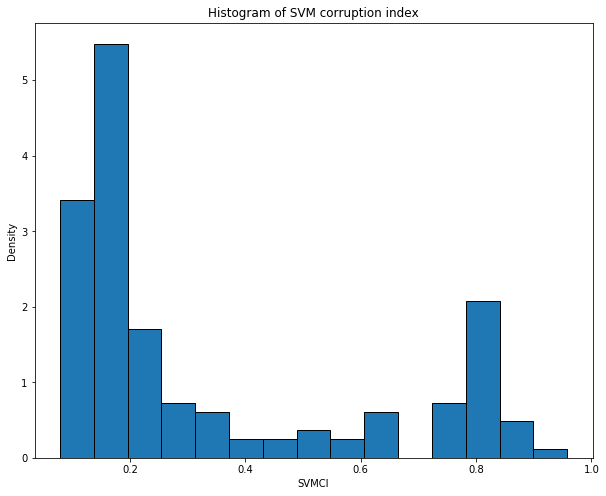

In [147]:
# plot the 2016

plt.figure(figsize=(10,8))
n_tot,bin_cuts,patches = plt.hist (ci_2016v, 15, density=True, edgecolor='black')
plt.xlabel('SVMCI')
plt.ylabel('Density')
plt.title('Histogram of SVM corruption index')

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 1000)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())

grid.fit(ci_2016v.reshape((140,1)))
band_2016=grid.best_params_["bandwidth"]

In [149]:
print(band_2016)

0.1


In [150]:
# prepare the plot

x_pts=np.linspace(0,1,1000).reshape((1000,1))

# 2016

ci_2016_kde=KernelDensity(bandwidth=band_2016,kernel='gaussian')
ci_2016_kde.fit(ci_2016v.reshape((140,1)))
fit_2016=ci_2016_kde.score_samples(x_pts).reshape((1000,1))

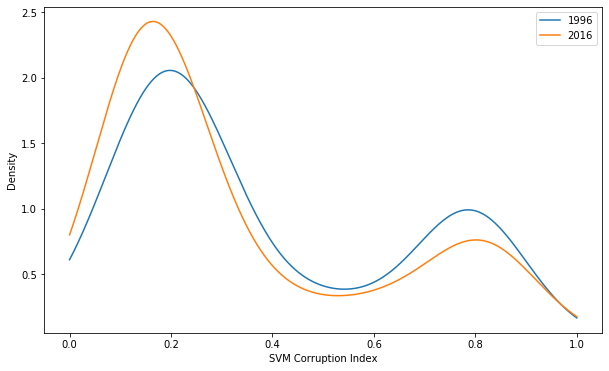

In [151]:
plt.figure(figsize=(10,6))
ax=plt.gca()

ax.plot(x_pts,np.exp(fit_1996),label='1996')
ax.plot(x_pts,np.exp(fit_2016),label='2016')
ax.set_xlabel('SVM Corruption Index')
ax.set_ylabel('Density')
ax.legend()